<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - francisco.olivars.14@sansano.usm.cl**_
* _**Gabriel Valenzuela - 201473505-7 - gabriel.valenzuel.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [ ]:
#Soy tu bloque pa' los imports papi
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed


#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

#Keras stuff
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.layers import Activation
from keras.regularizers import l1,l2
from keras import backend as K

#Que se vea ancho el jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


#Cantidad de columnas a mostrar con pandas
pd.set_option('display.max_columns',100)

Using TensorFlow backend.


<hr style="height:2px;border:none"/>

# Red neuronal Feed Forward para detectar Exoplanetas

Para comenzar, se cargarán los datos necesarios, los cuales tienen features extraidas a partir de las curvas de luz (intensidad de la luz en el tiempo) y metadatos de la observación [continuar con el relleno].

Desde el archivo _**koi sets unb**_ se obtiene el conjunto al que pertenece cada dato, los cuales pueden ser Test, Train y Unlabeled. Desde _**koi light curves**_ se obtienen las features extraidas a partir de las curvas de luz y los metadatos de la observación. Finalmente, desde _**koi labels**_ se obtendrán las etiquetas de cada exoplaneta, las cuales son _**CONFIRMED**_ o _**FALSE POSITIVE**_.

In [2]:
df_sets = pd.read_csv("data/koi_sets_unb.csv")

mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values

df_labels = pd.read_csv("data/koi_labels.csv")
df_X = pd.read_csv("data/koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]

Con los datos ya cargados, se generan las matrices para los conjuntos de entrenamiento y pruebas, como también se generan una etiqueta binaria para cada dato. Se realizar un boxplot para cada columna con datos numéricos, para observar la existencia de outliers.


In [3]:
y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)

In [4]:
def boxplotPlotTrain(column_name = 'Mean'):
    plt.figure()
    plt.title("Boxplot of "+column_name)
    plt.boxplot(df_X_train[column_name])
    plt.show()
    
numeric_columns = []
for i in df_X_train.columns:
    if np.issubdtype(df_X_train[i].dtype,np.number):
        numeric_columns.append(i)  
        
interact(boxplotPlotTrain, column_name=numeric_columns)        

interactive(children=(Dropdown(description='column_name', index=2, options=('Minimum', 'Maximum', 'Mean', 'Std…

<function __main__.boxplotPlotTrain(column_name='Mean')>

Se observa la presencia de outliers en la gran mayoría de los datos numéricos. Dado lo anterior, se toma la decisión que si existen datos nulos se reemplazarán con la mediana, dado que es un estadístico robusto frente outliers. 

In [5]:
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:]
X_test = df_X_test.values[:,1:]

> _**a) Explore los datos trabajados, ya sea con estadísticos simples o con gráficos como histogramas y/o boxplots. Comente sobre el problema enfrentado, es decir, la tarea de transformar un vector  𝑋  en un valor categórico (0 o 1).**_

El dataset cuenta con 41 atributos, cuyos nombres se presentan a continuación, 

In [6]:
columns_names = df_X_train.columns[1:]
columns_names

Index(['Minimum', 'Maximum', 'Mean', 'Std', 'IQR', 'Skew', 'Kurtosis', 'Q1',
       'Q2', 'Slope', 'Amplitude', 'MAD', 'Residual Bright Faint Ratio',
       'Median', 'Period', 'Time of Transit Epoch', 'First Transit Time (BJD)',
       'Impact Parameter', 'Duration', 'Transit Depth', 'r/R',
       'Fitted Stellar Density', 'Planet Radius', 'Semi-major Axis',
       'Inclination', 'Teq', 'Insolation Flux', 'a/R', 'Limb Darkening Coeff1',
       'Limb Darkening Coeff2', 'Limb Darkening Coeff3',
       'Limb Darkening Coeff4', 'Teff', 'log(g)', 'Metallicity',
       'Stellar Radius', 'Stellar Mass', 'Max single event sigma',
       'Max Multievent sigma', 'Transit Model SNR', 'KOI count'],
      dtype='object')

In [7]:
print(X_train.shape)
print(X_test.shape)


(4692, 41)
(1565, 41)


El conjunto de entrenamiento cuenta con 4692 registros, mientras que el conjunto de pruebas cuenta con 1565 registros.

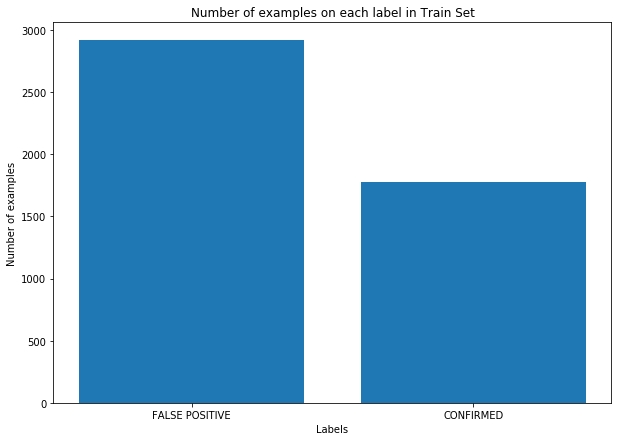

In [16]:
plt.figure(figsize=(10,7))
plt.title("Number of examples on each label in Train Set")
plt.bar(['0','1'],[len(y_train)-y_train.sum(),y_train.sum()])
plt.xlabel("Labels")
plt.ylabel("Number of examples")
plt.xticks([0,1],['FALSE POSITIVE','CONFIRMED'])
plt.show()

Se observa que las etiquetas del conjunto de entrenamiento se encuentran desbalanceadas, por que se espera que la red tienda a clasificar cada registro como FALSE POSITIVE, pues eso minimizaría su probabilidad de equivocarse. Por lo anterior, al momento de evaluar el desempeño de la red se debe considerar además otra métrica distinta de la _accuracy_, como el _F1 Score_.

A continuación se presentan distintos estadísticos para cada uno de los atributos

In [10]:
df_X_train.describe()

Minimum      Maximum         Mean          Std          IQR  \
count  4692.000000  4692.000000  4692.000000  4692.000000  4692.000000   
mean    -66.492676    23.987692    -0.142418     4.136842     0.333109   
std     274.391875   112.019945     0.501607    18.127797     2.060592   
min   -8446.637695     0.000000   -13.658888     0.000000     0.000000   
25%      -7.086795     0.167940    -0.028155     0.051691     0.002100   
50%      -1.620665     0.439595    -0.008431     0.105266     0.009035   
75%      -0.643782     2.028700    -0.002930     0.411105     0.028001   
max       0.000000  3780.657715     0.000000   686.443909    76.330341   

              Skew      Kurtosis           Q1           Q2         Slope  \
count  4692.000000   4692.000000  4692.000000  4692.000000  4.692000e+03   
mean     -9.386612    211.410321    -0.105753     0.017978  1.483853e-07   
std       9.112166    539.593897     0.450513     0.366224  7.449019e-06   
min    -117.225060     -3.000000   -11.479470    -1.961110 -1.280449e-04   
25%     -11.797075     17.711536    -0.014000    -0.001772 -3.708501e-08   
50%      -6.907724     58.183594    -0.003770     0.000000  0.000000e+00   
75%      -3.781710    170.416851    -0.000190     0.000000  4.254584e-08   
max      16.964659  16951.279152     5.092345    15.002840  1.998463e-04   

         Amplitude          MAD  Residual Bright Faint Ratio       Median  \
count  4692.000000  4692.000000                  4692.000000  4692.000000   
mean     45.240184     0.147191                   103.043248     0.017978   
std     190.309298     0.862019                   153.443064     0.366224   
min       0.000000     0.000000                     1.032485    -1.961110   
25%       0.418177     0.000670                    22.901289    -0.001772   
50%       1.056900     0.004060                    54.585001     0.000000   
75%       4.523286     0.011992                   118.101057     0.000000   
max    5550.700195    28.998531                  2709.687200    15.002840   

            Period  Time of Transit Epoch  First Transit Time (BJD)  \
count  4692.000000            4692.000000              4.692000e+03   
mean     39.181997             159.105302              2.454992e+06   
std      94.453978              61.608967              6.160896e+01   
min       0.299698             120.565925              2.454954e+06   
25%       2.068399             132.467184              2.454965e+06   
50%       7.096163             135.694975              2.454969e+06   
75%      23.561688             162.886710              2.454996e+06   
max    1071.232624            1472.522306              2.456306e+06   

       Impact Parameter     Duration  Transit Depth          r/R  \
count       4692.000000  4692.000000    4692.000000  4692.000000   
mean           0.664878     5.786126   40197.917882     0.211793   
std            0.934906     7.185999  105008.944336     0.856294   
min            0.000000     0.296100       0.800000     0.001000   
25%            0.248000     2.599597     206.600000     0.014000   
50%            0.618000     3.984500     622.200000     0.027000   
75%            0.922250     6.240750    6538.950000     0.261000   
max           25.224000   138.540000  921671.000000    24.663000   

       Fitted Stellar Density  Planet Radius  Semi-major Axis  Inclination  \
count             4692.000000    4692.000000      4692.000000  4692.000000   
mean                 3.246083      40.520243         0.162023    80.784582   
std                 20.059514     405.813248         0.252837    16.700814   
min                  0.000040       0.080000         0.006000     5.260000   
25%                  0.177645       1.600000         0.032000    81.320000   
50%                  0.719020       2.970000         0.072000    87.820000   
75%                  2.204478      33.412500         0.159000    89.520000   
max                839.902280   26042.900000         2.152000    90.000000   

         

Se observan grandes diferencias entre el mínimo y el segundo cuartil, como también entre el máximo y el tercer cuartil, lo que concuerda con lo mostrado por los boxplots anteriores. También se ven las diferencias entre la media y la mediana, lo que refuerza la decisión de usar un estadístico robusto frente a outliers.

Se genera un histograma y un boxplot para cada una de las columnas en ambos dataset.

In [11]:
def histAndBoxplot(column_name='Minimum', dataset='Train'):
    if(dataset=='Train'):
        df = df_X_train
    else:
        df = df_X_test
    plt.figure(figsize=(15,7))    
    plt.subplot(121)
    plt.title("Histogram of "+ column_name)
    plt.hist(df[column_name])
    plt.subplot(122)
    plt.title("Boxplot of " + column_name)
    plt.boxplot(df[column_name])
    plt.show()
    

In [27]:
interact(histAndBoxplot,column_name = columns_names,dataset=['Train','Test'])

interactive(children=(Dropdown(description='column_name', options=('Minimum', 'Maximum', 'Mean', 'Std', 'IQR',…

<function __main__.histAndBoxplot(column_name='Minimum', dataset='Train')>

Se observa una gran cantidad de outliers en casi todos los atributos. Una posible decisión sería eliminar algunos de ellos, pero como no se tienen conocimientos astronómicos sobre Exoplanetas se prefiere mantenerlos en el dataset, pues podrían ser elementos específicos de cierto tipo de objetos astronómicos.

El problema a enfrentar es el de clasificación entre dos clases mutuamente excluyentes. Por lo tanto, a partir de un vector se debe obtener un valor categórico, lo que de utilizar Redes Neuronales Feed Forward se puede lograr mediante la aplicación de transformaciones entre capas de neuronas, donde finalmente la capa de salida cuente solo con dos neuronas, cuyo resultado de computo entregará la probabilidad de pertenecer a cierta etiqueta o no. Al ser etiquetaas mutuamente excluyentes se debe utilizar una función de activación adecuada, como por ejemplo la función Soft-Max, lo que entregará ambos resultados entre 0 o 1, donde además la suma entre ellos da 1. Finalmente, para entregar un valor entre 0 y 1, se determina cual de las probabilidades entregadas es mayor, y en función de eso se retorna la etiqueta de la clase requerida.

Cabe destacar que para resolver este tipo de problemas se busca aproximar $P(y|x)$, es decir, la pertenencia a una determinada clase dado un ejemplo en específico. Por lo anterior, se requiere utilizar una función de perdida adecuada en el entrenamiento, como por ejemplo la Cross-Entropy Loss, la cual calcula las divergencias entre la función de probabilidad que se desea aproximar y la aproximación. Acá surge un nuevo problema en este caso, pues al tener clases desbalanceadas el clasificador tenderá a clasificar un mayor cantidad de ejemplos con la etiqueta de la clase dominante, debido a que la Cross-Entropy Loss funciona en base a _*accuracy*_, y al clasificar todo con la etiqueta de la clase dominante este valor tendería a ser más alto si es desbalance es demasiado.

> _**b) Escale los datos para ser trabajados por el modelo de aprendizaje, indique la importancia de éste paso. Además cree un conjunto de validación extrayendo un cierto porcentaje del conjunto de entrenamiento, por ejemplo el 20% manteniendo el desbalanceo de clases (split stratificado).**_

Se escalan los datos antes de trabajarlos con el modelo de aprendizaje, este paso es importante, pues al tener columnas con datos de distintas magnitudes, el modelo mayor importancia a aquellos atributos con magnitud más grande. En el caso de las Redes Neuronales Feed Forward, al momento de calcular la activación de cada capa. 

$$ a_i = \sigma\left( W_{i}^{T} \cdot a_{i-1} + b_{i}\right)$$

Al tener elementos con magnitudes más grandes afectarían directamente a las activaciones de las capas siguientes, por lo que un buen escalamiento de datos se hace realmente importante.

Además se separa un conjunto de validación, considerando un 20$\%$ de los datos del conjunto de entrenamiento, con el objetivo de usar dicho conjunto como un predictor del comportamiento en el conjunto de pruebas.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train,random_state=42)
print("Shape of X_train "+str(np.shape(X_train)))
print("Shape of X_val "+str(np.shape(X_val)))

Shape of X_train (3753, 41)
Shape of X_val (939, 41)


In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled =  scaler.transform(X_test)

c:\mauro\redesn~1\env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\mauro\redesn~1\env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\mauro\redesn~1\env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\mauro\redesn~1\env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


> _**c) Muestre en un gráfico la función objetivo (cross entropy) para el conjunto de entrenamiento y de validación vs número de epochs de entrenamiento, para una red feedforward de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 100 epochs de entrenamiento. Comente. Si observa divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento. Compare el efecto de variar la función de activación a ReLU ¿Qué observa en la convergencia del modelo?**_

In [13]:
def get_sequential_model(activation='sigmoid',lr=0.01,decay=0,momentum=0,nesterov=False):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation=activation))
    model.add(Dense(1, kernel_initializer='uniform',activation="sigmoid"))
    model.compile(optimizer=SGD(lr=lr,decay=decay,momentum=momentum,nesterov=nesterov),loss='binary_crossentropy')
    return model

Se entrenan dos redes distintas, una con función de activación sigmoidal y la otra con función de activación Relu. Para cada red se grafica el valor de su Loss Function en cada Epoch para los conjuntos de entrenamiento y validación. Como se está utilizando gradiente descendente estocástico, se repite el experiento 10 veces.

In [31]:
hist_list = []
hist_list_relu = []
epoch_list = [x for x in range(1,101)]
for i in range(10):
    model = get_sequential_model('sigmoid',lr=0.01)
    hist_list.append(model.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val)))
    model =get_sequential_model('relu',lr=0.01) 
    hist_list_relu.append(model.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val)))

Las redes entrenadas tienen la siguiente arquitectura

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 256)               10752     
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 257       
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


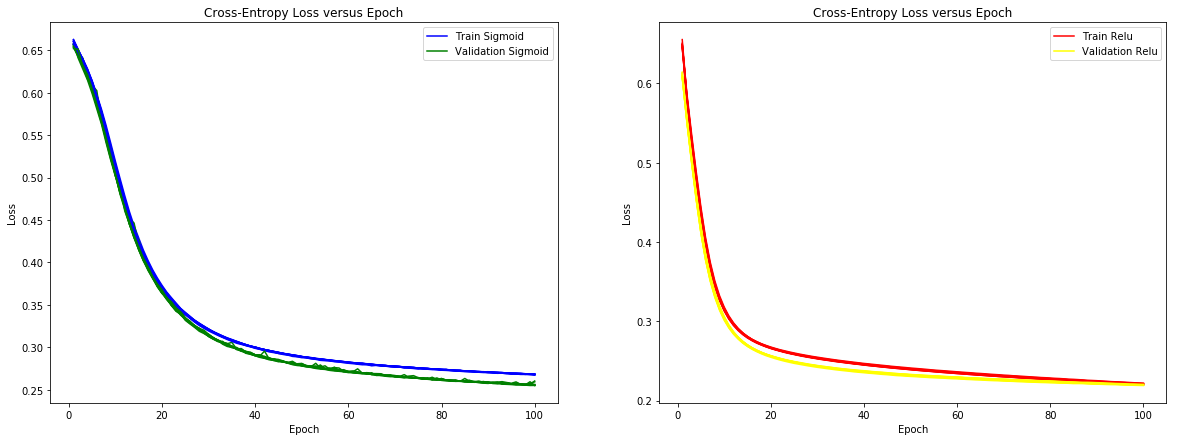

In [33]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.title('Cross-Entropy Loss versus Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')


for i in hist_list:
    plt.plot(epoch_list,i.history['loss'],color='blue')
    plt.plot(epoch_list,i.history['val_loss'],color='green')

plt.legend(['Train Sigmoid','Validation Sigmoid'],loc='upper right')
  
plt.subplot(122)
plt.title('Cross-Entropy Loss versus Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

for j in hist_list_relu:
    plt.plot(epoch_list,j.history['loss'],color='red')
    plt.plot(epoch_list,j.history['val_loss'],color='yellow')

plt.legend(['Train Relu','Validation Relu'],loc='upper right')
plt.show()  


Se observa que la red con función de activación _**ReLu**_ converge mucho más rápido que la red con activación _**Sigmoidal**_. Esto se debe a que la función rectificadora no está acotada por la derecha, lo que permite que las activaciones tengan un valor más alto que 1 y por ende pueda propagar mucho más rápido el error durante el _**Back Propagation**_. Por otro lado, no se observa divergencia durante el entrenamiento, y además se ve que se obtienen mejores resultados en el conjunto de validación que en el de entrenamiento.

> _**Finalmente compare a través de una métrica de desempeño sobre el conjunto de pruebas, en este caso como trabajamos un problema desbalanceado, mida f1 score weighted, comente sobre esta decisión ¿Es esperable la diferencia entre relu y sigmoidal en base a los gráficos realizados?**_

Para evaluar ambas redes se utiliza el f1 score, el cual trata de considerar la _**accuracy**_ y el _**recall**_. La precisión, en un problema de clasificación binario, se puede ver como la razón entre los verdaderos positivos y todos los valores entregados como positivos por el modelo. El recall en cambio, se puede ver como la razón entre los verdaderos positivos entre todos los valores verdaderos del conjunto. En problemas desbalanceados, si se considera solo la accuracy para evaluar los distintos modelos, se tenderá a elegir un modelo que clasifique la gran mayoría de los datos con los valores de la clase dominante, en cambio si se utiliza solo el recall para elegir el modelo, dicho modelo tenderá a clasificar todos los catos como la clase menos representada. Es por lo anterior que se utiliza el F1-Score, pues considera la media armónica entre ambas métricas.

$$ F1_{score} = 2\cdot\frac{precision \cdot recall}{precision + recall}$$


Considerando los gráficos anteriores de ambas redes, es de esperar que la red con activación ReLu obtenga mejores resultados pues llega a mejores resultados en menos iteraciones, lo que le permite ajustar de mejor manera sus parámetros entrenable que de utilizar la función de activación sigmoidal.

In [34]:
model_sigmoid = get_sequential_model(activation='sigmoid',lr=0.01)
model_sigmoid.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))

model_relu = get_sequential_model(activation='relu',lr=0.01) 
model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))

In [35]:
f1_score_sigmoid = f1_score(y_test,model_sigmoid.predict_classes(X_test_scaled),average='weighted')
f1_score_relu = f1_score(y_test,model_relu.predict_classes(X_test_scaled),average='weighted')

print("F1 Score Sigmoid: "+str(f1_score_sigmoid))
print("F1 Score Relu: "+str(f1_score_relu))

1344/1565 [========================>.....] - ETA: 0s F1 Score Sigmoid: 0.853281492111502
F1 Score Relu: 0.8696258446813638


Como era de esperar, la red con función de activación ReLu obtiene un F1-Score mejor que la red con función de activación Sigmoidal, con una diferencia de 3% aproximadamente.

> _**d) Repita c) variando la tasa de aprendizaje (learning rate) en un rango sensible. Comente. Si observa divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento o para alguna de las dos funciones de activación experimentadas.**_

Se utilizan 20 learning rates distintas, en un rango entre 0 y 1, para las redes entrenadas anteriormente. Por cada learning rate se entrenan 3 redes por cada función de activación, lo anterior por un tema de tiempo de entrenamiento, pues finalmente se terminan entrenando 120 redes.  

In [36]:
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)

def lr_experiment(iterations=3):
    
    lr_sigmoid_dict = dict()
    lr_relu_dict = dict()
    model_sigmoid_dict = dict()
    model_relu_dict = dict()
    for lr in learn_rate:
        sigmoid_list = []
        relu_list = []
        for i in range(iterations):
        # Training FF with sigmoid activation
            model_sigmoid = get_sequential_model(activation='sigmoid',lr=lr)
            hist_sigmoid = model_sigmoid.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            sigmoid_list.append(hist_sigmoid)
            # Training FF with relu activation
            model_relu = get_sequential_model(activation='relu',lr=lr)
            hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            relu_list.append(hist_relu)

        lr_sigmoid_dict[str(lr)] = sigmoid_list
        lr_relu_dict[str(lr)] = relu_list
        model_sigmoid_dict[str(lr)] = model_sigmoid
        model_relu_dict[str(lr)] = model_relu
    return lr_sigmoid_dict, lr_relu_dict, model_sigmoid_dict, model_relu_dict

In [37]:
lr_sigmoid_dict, lr_relu_dict, model_sigmoid_dict, model_relu_dict = lr_experiment(iterations=2)

In [38]:
def graph_loss_lr(lr,sigmoid_dict,relu_dict,model_sigmoid,model_relu):
    sig_list = sigmoid_dict[str(lr)]
    relu_list = relu_dict[str(lr)]
    plt.figure(figsize=(20,7))
    plt.subplot(121)

    plt.title("Cross-Entropy Loss, with sigmoid activation and lr = "+str(lr))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    for i in sig_list:
        plt.plot(epoch_list,i.history['loss'],color="blue")
        plt.plot(epoch_list,i.history['val_loss'],color="green")
    plt.legend(['Train set','Validation set'],loc='upper right')
    plt.subplot(122)
    plt.title("Cross-Entropy Loss, with relu activation and lr = "+str(lr))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    for i in relu_list:
        plt.plot(epoch_list,i.history['loss'],color="red")
        plt.plot(epoch_list,i.history['val_loss'],color="yellow")
    plt.legend(['Train Set','Validation Set'],loc='upper right')
    plt.show()
    f1_score_sigmoid = f1_score(y_test,model_sigmoid[str(lr)].predict_classes(X_test_scaled),average='weighted')
    f1_score_relu = f1_score(y_test,model_relu[str(lr)].predict_classes(X_test_scaled),average='weighted')
    print("F1 Score Sigmoid: "+str(f1_score_sigmoid))
    print("F1 Score Relu: "+str(f1_score_relu))

In [39]:
epoch_list = [x for x in range(1,101)]
interact(graph_loss_lr, lr=learn_rate, sigmoid_dict=fixed(lr_sigmoid_dict),relu_dict=fixed(lr_relu_dict),model_sigmoid=fixed(model_sigmoid_dict),model_relu=fixed(model_relu_dict))

interactive(children=(Dropdown(description='lr', options=(0.0, 0.05263157894736842, 0.10526315789473684, 0.157…

<function __main__.graph_loss_lr(lr, sigmoid_dict, relu_dict, model_sigmoid, model_relu)>

Como es de esperar, cuando se utiliza 0 como learning rate se obtienen resultados determinados por la inicialización de los pesos (glorot uniforme por defecto). Algo interesante en este caso es que los 2 de los 3 experiemtos realizados con Relu tienen peor desempeño que los realizados con la función de activación Sigmoidal, sin embargo, si se considera solo la primera ejecución el F1-Score con Relu es bastante peor que el con sigmoidal, aún así ambos son bastante deficientes. Al aumentar el learning rate a 0.05 se observa que ambos métodos convergen, pero se comienza a producir overfitting en las redes entrenadas con activación relu, además se comienzan a observar ligeros aumentos en el conjunto de validación de ambas redes, lo que se debe a que teóricamente la técnica de Gradiente Descendente Estocástico no asegura que la última iteración sea la mejor, si no que puede aparecer antes. Los aumentos anteriores se hacen más pronunciados debido a que las actualizaciones de los pesos son más bruscas debido al aumento en la learning rate. Aumentando el learning rate a 0.10 se puede ver como aumenta el overfitting en la red con activación ReLu, y además se observa que los aumentos en el conjunto de validación de la red con activación Relu se comiezan a intensificar en comparación a los de la red con activación sigmoidal, esto podría indicar que al seguir aumentando la tasa de aprendizaje lo más probable es que la red con activación Relu comience a diverger primero. Aumentando la tasa a 0.15 se intensifican aún más los aumentos en ambas redes, siendo aún más pronunciados los aumentos en la red con activación Sigmoidal, llegando uno de los spikes a una loss de 0.6. También se puede observar como aumenta el overfitting en la red con activación relu. 

A medida que se sigue aumentando la tasa de aprendizaje los F1-Score comienzan a aumentar mientras aumenta la lr, pero siendo mejor los de la red con activación Sigmoidal, donde no se aprecia tanto overfit como en la red con activación ReLu. Pero también aumentan el tamaño de spikes presentes en la red con activación sigmoidal, como también ahora en la red con activación ReLu. Al llegar a una tasa de aprendizaje de 0.47 se comienza a notar más el overfit en la red con activación sigmoidal, en este caso la red con activación Relu obtiene un mejor F1-Score que la red con activación Sigmoidal con una diferencia del 1%. Con una learning rate de 0.52 se observa como una de las ejecuciones de la red con activación sigmoidal diverge completamente, llegando a un valor de loss de 6 en ambos conjuntos (validación y testing), situación que no se da en la red con activación ReLu, pero sin embargo en esta última los spikes comienzan a llegar a valores más altos. Con una tasa de 0.57 las tres ejecuciones con red de activación Sigmoidad divergen, llegando a un F1-Score de aproximadamente 0.5, en cambio la red con activación sigmoidal sigue obteniendo resultados buenos ($\approx$ 0.8) a pesar de el overfit presenciado. La situación presenciada hasta el momento no cambia para la red con activación ReLu, llegando a un F1-Score de 0.87 con lr igual a 1, mientras que la red con activación sigmoidal llega a un pobre 0.16.

In [175]:
def plot_loss_static(variable_list,sigmoid_dict,relu_dict,dataset='train'):
    sigmoid_list = []
    relu_list = []
    plt.figure(figsize=(20,7))
    for i in variable_list:
        sigmoid_list.append(sigmoid_dict[str(i)][0])
        relu_list.append(relu_dict[str(i)][0])   
    plt.subplot(121)
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(variable_list)
    if(dataset=='train'):
        for i in sigmoid_list:
            plt.plot(epoch_list,i.history['loss'])
        plt.title("Cross-Validation Loss versus Epoch with Sigmoid Activation in Train set")
    else:
        for i in sigmoid_list:
            plt.plot(epoch_list,i.history['val_loss'])
        plt.title("Cross-Validation Loss versus Epoch with Sigmoid Activation in validation set")
    plt.legend(variable_list,loc='upper right')    
    plt.subplot(122)
    if(dataset=='train'):
        for i in relu_list:
            plt.plot(epoch_list,i.history['loss'])
        plt.title("Cross-Validation Loss versus Epoch with Relu Activation in Train set")
    else:
        for i in relu_list:
            plt.plot(epoch_list,i.history['val_loss'])
        plt.title("Cross-Validation Loss versus Epoch with Relu Activation in Validation set")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(variable_list,loc='upper right')
    plt.show()

Debido a que los resultados se presentan a través de Widget de IPython, los cuales no quedan con los resultados en caché para su utilización, se presentan los resultados utilizando todas las tasas de aprendizaje en un mismo gráfico, considerando ambas funciones de activación y ambos conjuntos de datos.

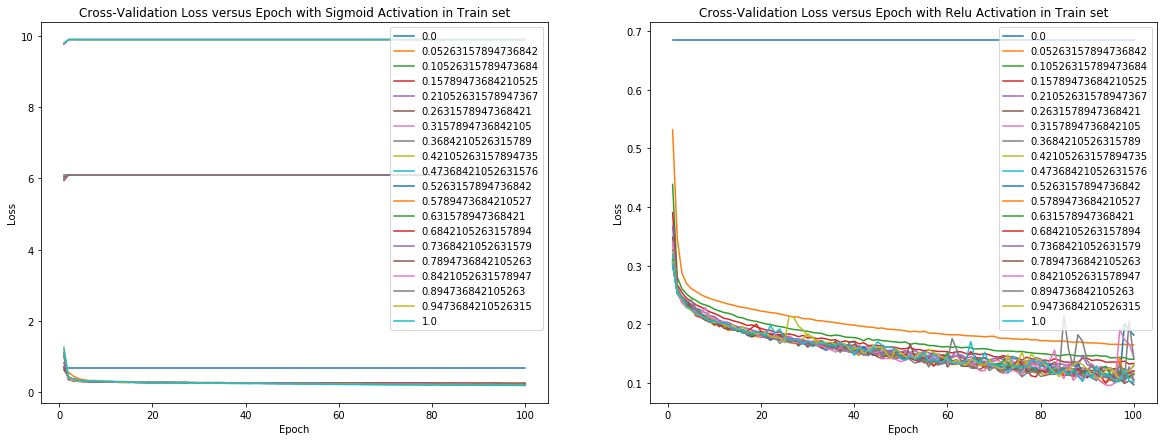

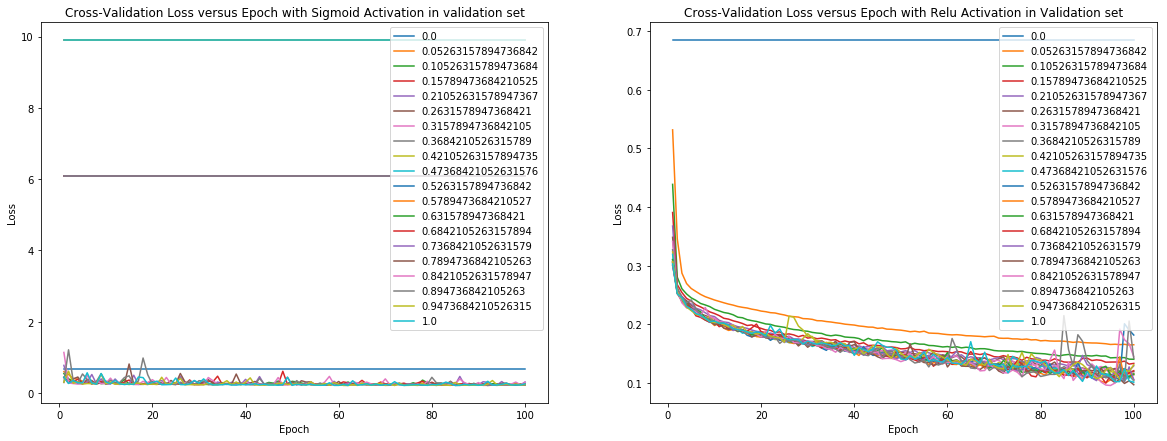

In [157]:
plot_loss_static(learn_rate,lr_sigmoid_dict,lr_relu_dict)
plot_loss_static(learn_rate,lr_sigmoid_dict,lr_relu_dict,"val")

> _**e) Entrene los modelos considerados en c) usando progressive decay. Compare y comente.**_

_Progressive Decay_ consiste en disminuir la tasa de aprendizaje conforme transcurre el entrenamiento. Este decaimiento se realiza de la siguiente manera.

$$ \eta_{t} = \frac{\eta_{0}}{1 + t \cdot \eta_{d}}$$

Donde $\eta_{d}$ es conocido como tasa de decaimiento y $\eta_{0}$ es la tasa de decaimiento inicial.

Dada la formulación anterior, la tasa entrenamiento a utilizar siempre decaerá linealmente, independiente del contexto en el que se encuentre el aprendizaje. Tal como se muestra en el siguiente gráfico.

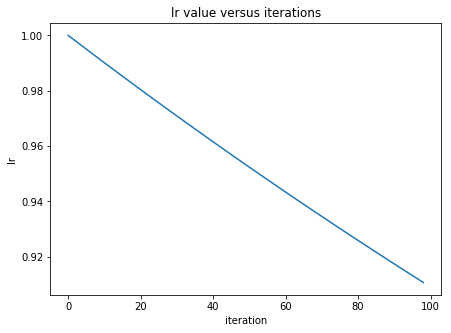

In [163]:
def eta_plot(lr,decay,iterations=100):
    eta_list = []
    eta_actual = lr
    for i in range(1,iterations):
        eta_list.append(eta_actual)
        eta_actual = lr/(1 + (i*decay))
    plt.figure(figsize=(7,5))
    plt.title("lr value versus iterations")
    plt.ylabel("lr")
    plt.xlabel("iteration")
    plt.plot(eta_list)
    plt.show()
    
eta_plot(1,0.001)    

Se repite el experimento realizado, pero ahora utilizando _progressive decay_ para entrenar. En este caso se utilizan 10 constantes de decaimiento distintas, obtenidas desde una escala logarítmica con exponentes entre -6 y 0. Se espera que mientras se aumente la constante el entrenamiento se estanque más rápido el entrenamiento, pues la disminución de la tasa de entrenamiento será más brusca a medida que se aumenta la tasa de decaimiento.

In [42]:
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)
def decay_experiment(iterations=3,lr=0.01):
    decay_sigmoid_dict = dict()
    decay_relu_dict = dict()
    model_decay_sigmoid_dict = dict()
    model_decay_relu_dict = dict()
    for decay in lear_decay:
        sigmoid_list = []
        relu_list = []
        for i in range(iterations):
        # Training FF with sigmoid activation
            model_sigmoid = get_sequential_model(activation='sigmoid',decay=decay)
            hist_sigmoid = model_sigmoid.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            sigmoid_list.append(hist_sigmoid)
            # Training FF with relu activation
            model_relu = get_sequential_model(activation='relu',decay=decay)
            hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            relu_list.append(hist_relu)

        decay_sigmoid_dict[str(decay)] = sigmoid_list
        decay_relu_dict[str(decay)] = relu_list
        model_decay_sigmoid_dict[str(decay)] = model_sigmoid
        model_decay_relu_dict[str(decay)] = model_relu
    return decay_sigmoid_dict, decay_relu_dict, model_decay_sigmoid_dict, model_decay_relu_dict

In [49]:
decay_sigmoid, decay_relu, model_decay_sigmoid, model_decay_relu = decay_experiment(iterations=2)

In [50]:
def plot_loss_decay(decay, decay_sigmoid_dict,decay_relu_dict,model_decay_sigmoid_dict,model_decay_relu_dict):
    sig_list = decay_sigmoid_dict[str(decay)]
    relu_list = decay_relu_dict[str(decay)]
    plt.figure(figsize=(20,7))
    plt.subplot(121)

    plt.title("Cross-Entropy Loss, with sigmoid activation and decay = "+str(decay))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    for i in sig_list:
        plt.plot(epoch_list,i.history['loss'],color="blue")
        plt.plot(epoch_list,i.history['val_loss'],color="green")
    plt.legend(['Train set','Validation set'],loc='upper right')
    plt.subplot(122)
    plt.title("Cross-Entropy Loss, with relu activation and decay = "+str(decay))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    for i in relu_list: 
        plt.plot(epoch_list,i.history['loss'],color="red")
        plt.plot(epoch_list,i.history['val_loss'],color="yellow")
    plt.legend(['Train Set','Validation Set'],loc='upper right')
    plt.show()
    f1_score_sigmoid = f1_score(y_test,model_decay_sigmoid_dict[str(decay)].predict_classes(X_test_scaled),average='weighted')
    f1_score_relu = f1_score(y_test,model_decay_relu_dict[str(decay)].predict_classes(X_test_scaled),average='weighted')
    print("F1 Score Sigmoid: "+str(f1_score_sigmoid))
    print("F1 Score Relu: "+str(f1_score_relu))

In [51]:
 epoch_list = [x for x in range(1,101)]
interact(plot_loss_decay, decay=lear_decay, decay_sigmoid_dict=fixed(decay_sigmoid), decay_relu_dict=fixed(decay_relu), model_decay_sigmoid_dict=fixed(model_decay_sigmoid), model_decay_relu_dict=fixed(model_decay_relu))

interactive(children=(Dropdown(description='decay', options=(1e-06, 4.641588833612782e-06, 2.1544346900318823e…

<function __main__.plot_loss_decay(decay, decay_sigmoid_dict, decay_relu_dict, model_decay_sigmoid_dict, model_decay_relu_dict)>

Se utiliza una learning rate inicial de 0.01. Al utilizar una tasa de decaimiento de $10^{-6}$ se observa una convergencia similar a la obtenida al experimento realizado en el ítem _**b)**_, por lo que no se nota el efecto del _progressive decay_, llegando a F1-Scores similares. Al utilizar una tasa del orden de $10^{-5}$ se observa una ligera disminución en el F1-Score, así como se observa que la curva de convergencia se comienza a "estirar" sobre el eje horizontal. Este estiramiento en la curva de convergencia se comienza a hacer más visible en ambas redes al utilizar una tasa del orden de $10^{-3}$, siendo más notable en la curva de la red con activación Sigmoidal, además se comienzan a obtener peores valores de loss y de F1-Score. Lo anterior se hace mucho más notorio a partir de una tasa de 0.01, donde se ve que el rango del eje y es mucho más reducido a pesar de la forma que se observa en la curva, lo que da a entender que a comparación de las curvas anteriores estas varian mucho menos su loss. Al seguir aumentando la tasa de decaimiento se observa como el valor de la loss prácticamente no cambia a medida que pasan los Epoch, dando a entender que el descenso en la tasa de aprendizaje es muy brusco al principio, por lo que las actualizaciones de pesos en cada Epoch son muy pequeñas. De ahí en adelante las curvas de convergencia son prácticamente horizontales, llegando a F1-scores de entre 0.5 y 0.6.

Lo descrito anteriormente se observa de mejor manera en los siguientes gráficos, donde se observan las curvas de convergencia para cada tasa de decaimiento en el mismo gráfico.

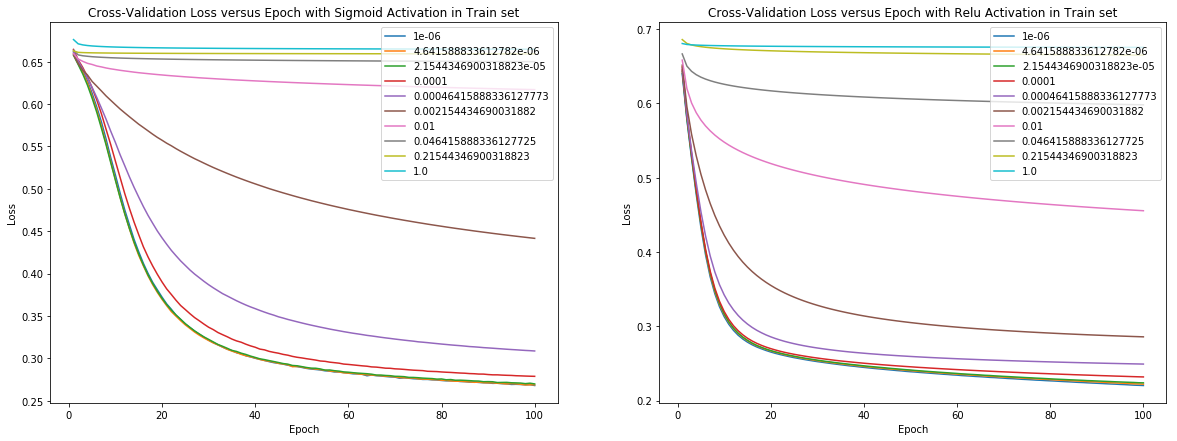

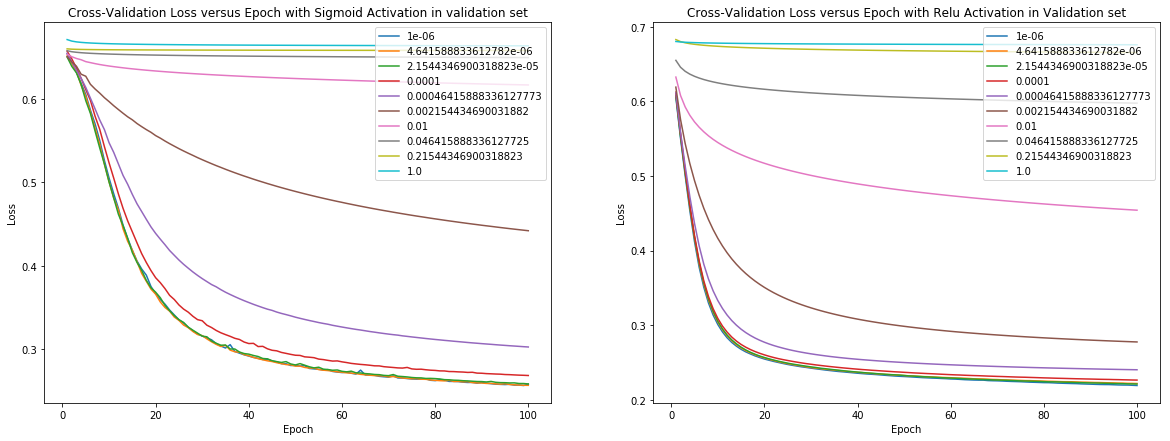

In [176]:
plot_loss_static(lear_decay,decay_sigmoid,decay_relu)
plot_loss_static(lear_decay,decay_sigmoid,decay_relu,"val")

Al comenzar a aumentar la tasa de decaimiento se comienza a observar como cambia la forma de la curva presentada, haciendose "más plana" cada vez, al usar una tasa de decaimiento de 0.01 se observa una gran disminución en el F1 Score que se venía obteniendo con las tasas anteriores, pasando aproximadamente de 0.79 a 0.54, el cual no cambia si se sigue aumentando dicha tasa. Esto se debe a que a partir de 0.01 la tasa de decaimiento provoca que se disminuya completamente la tasa de aprendizaje inicial, la cual fue seteada en 0.01. Dado lo anterior, se decide cambiar la tasa inicial de aprendizaje a un valor más alto.

In [53]:
histdecay_sigmoid_dict, histdecay_relu_dict, modeldecay_sigmoid_dict, modeldecay_relu_dict = decay_experiment(1,1)

In [55]:
epoch_list = [x for x in range(1,101)]
interact(plot_loss_decay, decay=lear_decay, decay_sigmoid_dict=fixed(histdecay_sigmoid_dict), decay_relu_dict=fixed(histdecay_relu_dict), model_decay_sigmoid_dict=fixed(modeldecay_sigmoid_dict), model_decay_relu_dict=fixed(modeldecay_relu_dict))

interactive(children=(Dropdown(description='decay', options=(1e-06, 4.641588833612782e-06, 2.1544346900318823e…

<function __main__.plot_loss_decay(decay, decay_sigmoid_dict, decay_relu_dict, model_decay_sigmoid_dict, model_decay_relu_dict)>

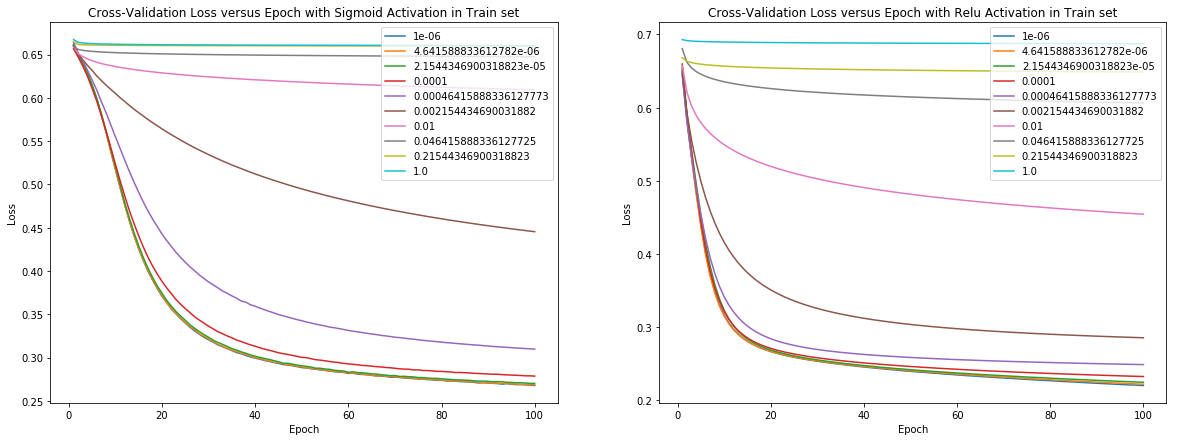

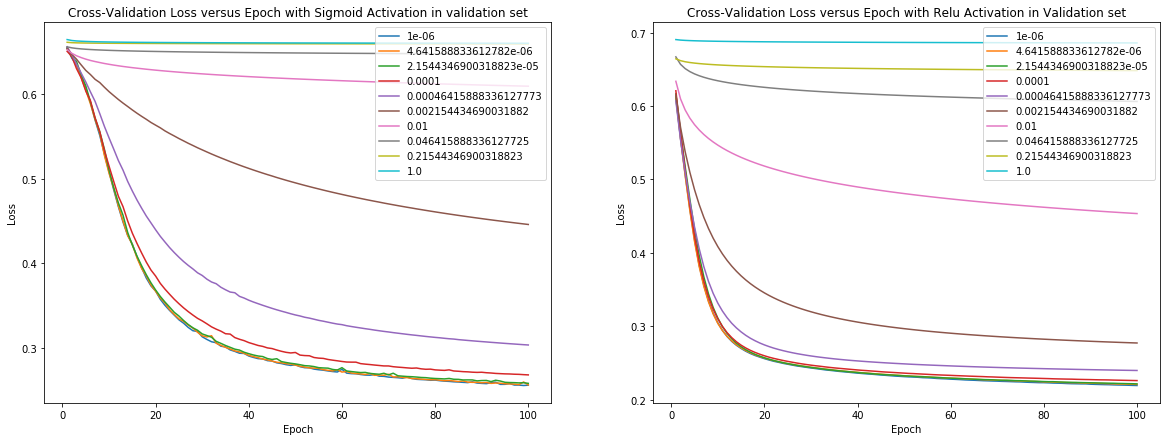

In [178]:
plot_loss_static(lear_decay,histdecay_sigmoid_dict,histdecay_relu_dict)
plot_loss_static(lear_decay,histdecay_sigmoid_dict,histdecay_relu_dict,"val")

Ahora el decaimiento se puede utilizar con valores altos, pero no implica una mejora en los F1-Scores obtenidos para una misma tasa de decaimiento (en valores altos), por lo que de utilizar tasa de decaimiento, se determina que es mejor utilizar valores bajos en conjunto a la learning rate de 0.01 (o similar).

> _**f) Entrene los modelos considerados en c) usando momentum. Experimente usando momentum clásico y momentum de Nesterov. ¿Observa un mejor resultado final? ¿Observa una mayor velocidad de convergencia sobre el conjunto de entrenamiento? ¿Sobre el conjunto de validación?**_

Las técnicas basadas en momentum tratan de mejorar la velocidad de convergencia de BP en escenarios de alta curvatura, como el presentado en el siguiente ejemplo.

<img src="./img/momen.png" title="Title text" width="35%" height="35%" />

Para producir lo anterior, mantienen una estimación de las direcciones recientes que a tomado el algoritmo, para solo modificar parcialmente esta dirección con la información del gradiente actual, lo que permite salir de áreas donde la dirección del gradiente es muy variable (como los puntos cercanos a un punto silla).

En el caso del Momentum normal, los pesos se actulizan en base al peso en la iteración anterior y una velocidad, la cual para actualizarse considera el gradiente actual y las velocidades pasadas, y por ende los gradiantes actuales.

$$ g_t \leftarrow \text{Gradiente estimado}$$
$$ v_{t+1} \leftarrow \gamma v_t + \eta g_t$$
$$ w^{(t+1)} \leftarrow w^{(t)} - v_{t+1} $$

Donde $\gamma$ se conoce como parámetro de momentum. Esta manera de actualizar los pesos ayuda a evitar el zigzag que se produce en el escenario de la imagen anterior.

En el caso del Momentum de Nesterov, se intenta usar una mejor estimación del gradiente que en el caso del Momentum normal. Para lo anterior, se considera un nuevo punto para estimar el gradiente, que es el punto en el que se estaría si sólo se considera la velocidad.

$$ g_t \approx \nabla E(w^{(t)} - \gamma v_t) $$
$$ v_{t+1} \leftarrow \gamma v_t + \eta g_t $$
$$ w^{t+1} \leftarrow w^{(t)} - v_{t+1} $$

Se volverá a repetir el experimento realizado en _**c)**_, pero esta vez utilizando ambas técnicas de momentum. Se variará el parámetro de momentum utilizando 20 muestras desde una escala lineal entre 0 y 1.

### Momentum Normal

In [58]:
split_space = 20
momentum_list = np.linspace(0,1,split_space)


def momentum_experiment(iterations=3, lr=0.01):
    momentum_sigmoid_dict = dict()
    momentum_relu_dict = dict()
    model_momentum_sigmoid_dict = dict()
    model_momentum_relu_dict = dict()
    for mom in momentum_list:
        sigmoid_list = []
        relu_list = []
        for i in range(iterations):
        # Training FF with sigmoid activation
            model_sigmoid = get_sequential_model(activation='sigmoid',momentum=mom)
            hist_sigmoid = model_sigmoid.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            sigmoid_list.append(hist_sigmoid)
            # Training FF with relu activation
            model_relu = get_sequential_model(activation='relu',momentum=mom)
            hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            relu_list.append(hist_relu)

        momentum_sigmoid_dict[str(mom)] = sigmoid_list
        momentum_relu_dict[str(mom)] = relu_list
        model_momentum_sigmoid_dict[str(mom)] = model_sigmoid
        model_momentum_relu_dict[str(mom)] = model_relu
    return momentum_sigmoid_dict, momentum_relu_dict, model_momentum_sigmoid_dict, model_momentum_relu_dict
    

In [59]:
def plot_loss_momentum(momentum, momentum_sigmoid_dict,momentum_relu_dict,model_momentum_sigmoid_dict,model_momentum_relu_dict,nesterov=False):
    sig_list = momentum_sigmoid_dict[str(momentum)]
    relu_list = momentum_relu_dict[str(momentum)]
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.title("Cross-Entropy Loss, with sigmoid activation and momentum = "+str(momentum))
    if nesterov:
        plt.suptitle("Using Nesterov Momentum")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    for i in sig_list:
        plt.plot(epoch_list,i.history['loss'],color="blue")
        plt.plot(epoch_list,i.history['val_loss'],color="green")
    plt.legend(['Train set','Validation set'],loc='upper right')
    plt.subplot(122)
    plt.title("Cross-Entropy Loss, with relu activation and momentum = "+str(momentum))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    for i in relu_list:
        plt.plot(epoch_list,i.history['loss'],color="red")
        plt.plot(epoch_list,i.history['val_loss'],color="yellow")
    plt.legend(['Train Set','Validation Set'],loc='upper right')
    plt.show()
    f1_score_sigmoid = f1_score(y_test,model_momentum_sigmoid_dict[str(momentum)].predict_classes(X_test_scaled),average='weighted')
    f1_score_relu = f1_score(y_test,model_momentum_relu_dict[str(momentum)].predict_classes(X_test_scaled),average='weighted')
    print("F1 Score Sigmoid: "+str(f1_score_sigmoid))
    print("F1 Score Relu: "+str(f1_score_relu))

In [60]:
mom_sig_dict, mom_relu_dict, model_mom_sig, model_mom_relu = momentum_experiment()

In [62]:
interact(plot_loss_momentum, momentum=momentum_list, momentum_sigmoid_dict=fixed(mom_sig_dict), momentum_relu_dict=fixed(mom_relu_dict), model_momentum_sigmoid_dict=fixed(model_mom_sig), model_momentum_relu_dict=fixed(model_mom_relu),nesterov=fixed(False))

interactive(children=(Dropdown(description='momentum', options=(0.0, 0.05263157894736842, 0.10526315789473684,…

<function __main__.plot_loss_momentum(momentum, momentum_sigmoid_dict, momentum_relu_dict, model_momentum_sigmoid_dict, model_momentum_relu_dict, nesterov=False)>

Al utilizar un parámetro de momentum igual a 0 se obtienen los mismo resultados que en _**c)**_, lo que es de esperar pues con esto no se consideran los gradientes de las iteraciones anteriores. Al utilizar un valor de 0.05 no se observa un cambio de forma muy pronunciado en las curvas de convergencia, pero si se observa que se obtienen mejores resultados en el conjunto de validación que en el conjunto de pruebas por un muy ligero margen. Se comienza a aumentar el parámetro de momentum, pero no se observan cambos muy pronunciados, pero si se observa que el punto de inflexión de la curva comienza a acercarse hacia el eje y, indicando que la convergencia se hacer más rápida. Los resultados en términos de F1-Score no varían demasiado. Cabe destacar que para un parámetro de 0.36 se invierte la relación entre los resultados obtenidos en el conjunto de validación y entrenamiento en la red con activación ReLu, siendo ahora el set de entrenamiento el que obtiene mejores resultados. La situación anterior se acentua al aumentar el valor del parámetro de momentum, aumentando el overfit producido en la red con activación Relu, el cual no se da en la red con activación Sigmoidal.

Los spikes producidos en el experimento donde se varió la tasa de aprendizaje vuelven a aparecer levemente al utilizar valores altos para el parámetro de momentum (0.94), además se observan mejores resultados en la red con activación Sigmoidal en terminos de F1-Score.

Por otro lado, al utilizar un valor de parámetro igual a 1, se observa divergencia total en ambas redes, siendo más pronunciado en la red con activación ReLu. Lo anterior se debe a que se privilegia practicamente sólo la velocidad, por lo que llega un momento en que las direcciones anteriores no sirven para acercarse en dirección a un óptimo.

Las diferencias en las velocidades de convergencia para cada red en cada conjunto se pueden ver en los siguientes gráficos.

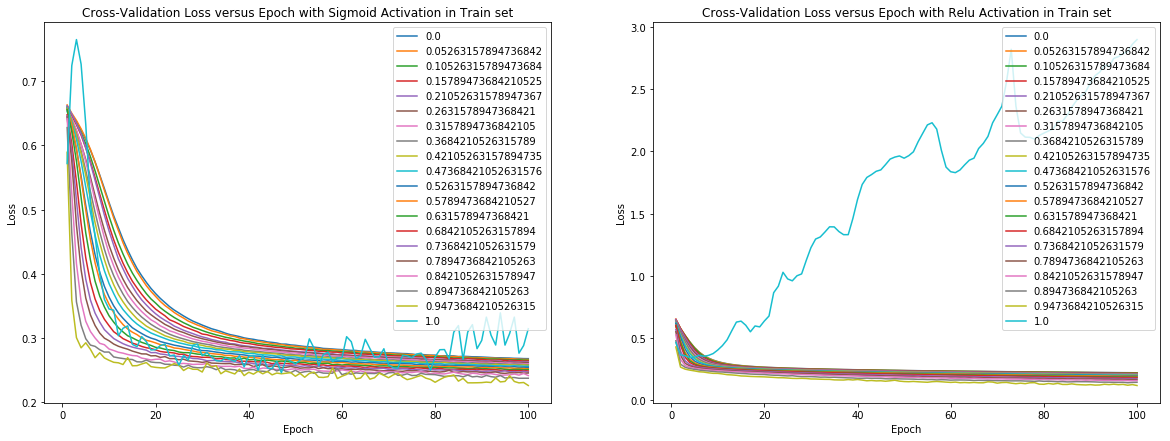

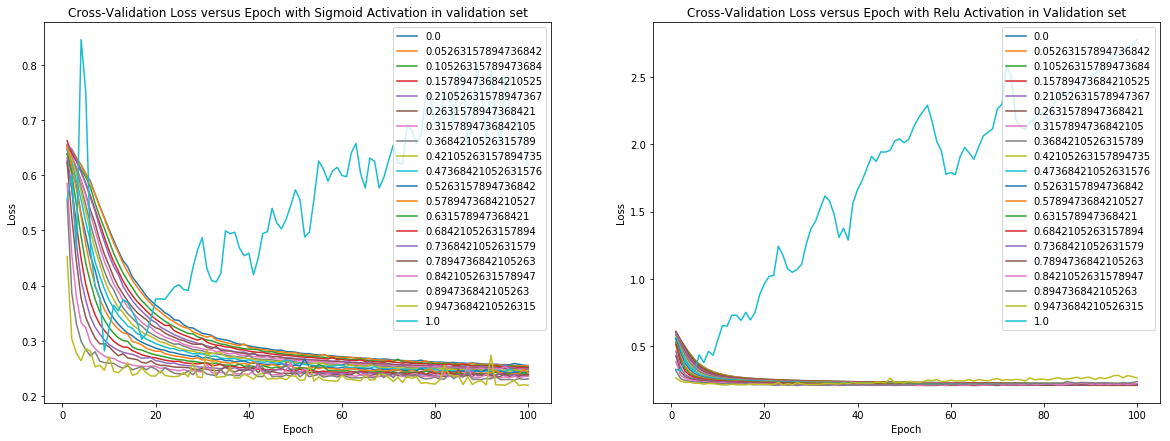

In [179]:
plot_loss_static(momentum_list,mom_sig_dict,mom_relu_dict)
plot_loss_static(momentum_list,mom_sig_dict,mom_relu_dict,"val")

### Nesterov Momentum

In [65]:
split_space = 20
momentum_list = np.linspace(0,1,split_space)


def momentum_nesterov_experiment(iterations=1, lr=0.01):
    momentum_sigmoid_dict = dict()
    momentum_relu_dict = dict()
    model_momentum_sigmoid_dict = dict()
    model_momentum_relu_dict = dict()
    for mom in momentum_list:
        sigmoid_list = []
        relu_list = []
        for i in range(iterations):
        # Training FF with sigmoid activation
            model_sigmoid = get_sequential_model(activation='sigmoid',momentum=mom,nesterov=True)
            hist_sigmoid = model_sigmoid.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            sigmoid_list.append(hist_sigmoid)
            # Training FF with relu activation
            model_relu = get_sequential_model(activation='relu',momentum=mom)
            hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            relu_list.append(hist_relu)

        momentum_sigmoid_dict[str(mom)] = sigmoid_list
        momentum_relu_dict[str(mom)] = relu_list
        model_momentum_sigmoid_dict[str(mom)] = model_sigmoid
        model_momentum_relu_dict[str(mom)] = model_relu
    return momentum_sigmoid_dict, momentum_relu_dict, model_momentum_sigmoid_dict, model_momentum_relu_dict
    

In [67]:
momn_sig_dict, momn_relu_dict, model_momn_sig, model_momn_relu = momentum_nesterov_experiment()

In [68]:
interact(plot_loss_momentum, momentum=momentum_list, momentum_sigmoid_dict=fixed(momn_sig_dict), momentum_relu_dict=fixed(momn_relu_dict), model_momentum_sigmoid_dict=fixed(model_momn_sig), model_momentum_relu_dict=fixed(model_momn_relu),nesterov=fixed(True))

interactive(children=(Dropdown(description='momentum', options=(0.0, 0.05263157894736842, 0.10526315789473684,…

<function __main__.plot_loss_momentum(momentum, momentum_sigmoid_dict, momentum_relu_dict, model_momentum_sigmoid_dict, model_momentum_relu_dict, nesterov=False)>

En el caso del Momentum de Nesterov, se observan comportamiento similares que en el momentum normal, pero el overfit producido en la red con activación ReLu se comienza a observar para un valor de parámetro de 0.26 en lugar de 0.36, por lo que se presume que la nueva estimación del gradiente acentua el overfit que se produce en dicha red, lo que puede indicar una convergencia más rápida con momentum de Nesterov, lo cual es algo de esperar debido a que el Momentum de Nesterov tiene la garantía teórica de ser el algoritmo de primer orden con mejor tasa de convergencia. 

Tal como se planteó anteriormente, el overfit en la red con activación ReLu se acentuó al utilizar este algoritmo, pero por otro lado, en la red con activación Sigmoidal no se producen spikes tan pronunciados como con el momentum normal, al considerar un parámetro de momentum de 0.94. Cuando se utiliza un parámetro igual a 1 se produce algo interesante en la red con activación Sigmoidal, pues el conjunto de entrenamiento no divergen inmediatamente como sucedia en el caso del momentum normal.

Las diferencia en las curvas de convergencia de cada red y conjunto de datos para los distintos valores del parámetro de momentum utilizando el momentum de Nesterov se presentan en los siguientes gráficos.

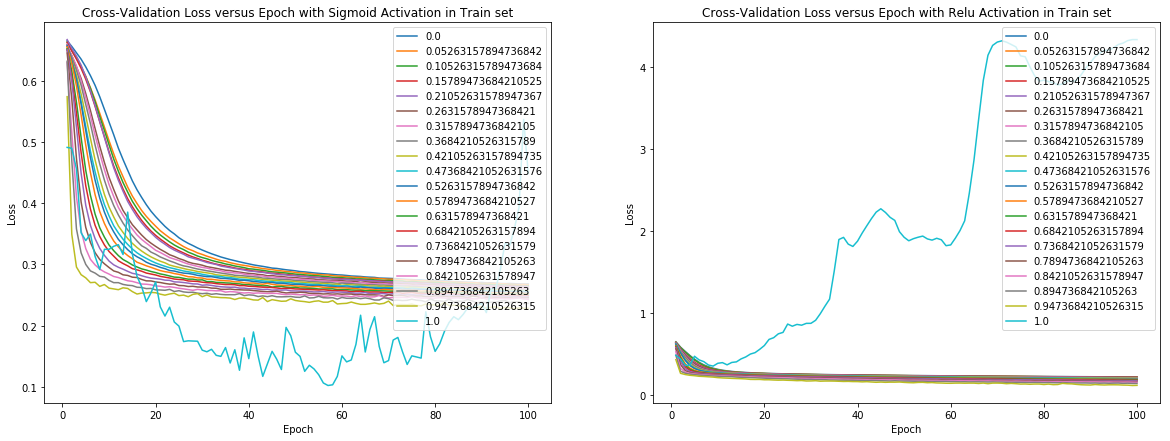

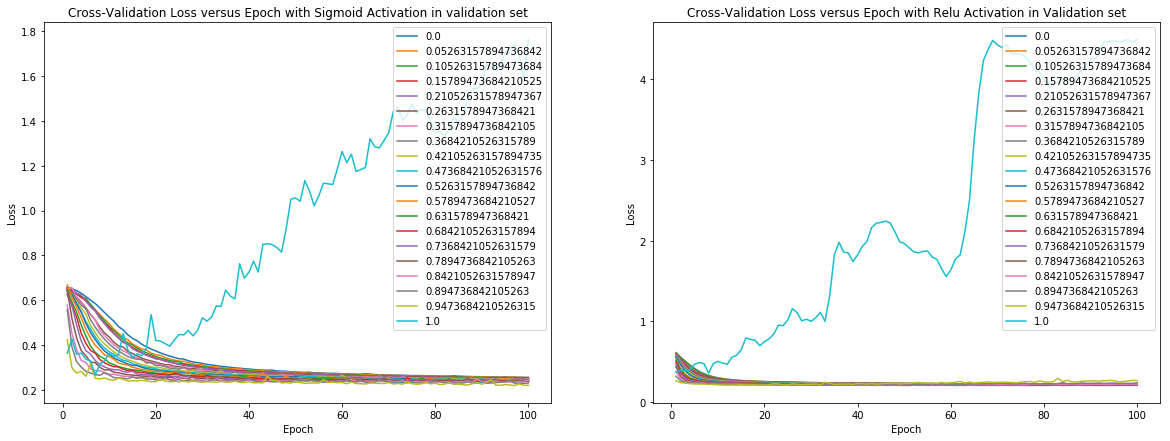

In [180]:
plot_loss_static(momentum_list,momn_sig_dict,momn_relu_dict)
plot_loss_static(momentum_list,momn_sig_dict,momn_relu_dict,"val")

> _**g) Vuelva a entrenar los modelos considerados en c) utilizando SGD en mini-batches. Experimente con diferentes tamaños del batch. Comente sobre eficacia de convergencia (converge en menor número de epochs) vs eficiencia computacional (tiempo en converger o por epoch).**_

SGD con mini batches utiliza un determinado subconjunto de ejemplos con el objetivo de mejorar la aproximación del gradiente que utiliza SDG (1 ejemplo), por lo que el ajuste debería ser mejor, aunque realiza menos actualizaciones de pesos por Epoch, debido a que 1 Epoch es una pasada completa por el conjunto de entrenamiento.

Para este experimento se utilizarán 21 tamaños de batch distintos, obtenidos a partir de un espacio lineal entre 1 y el número de ejemplos en el conjunto de entrenamiento.

In [85]:
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))

def batch_experiment(iterations=1):
    batch_sigmoid_dict = dict()
    batch_relu_dict = dict()
    model_batch_sigmoid_dict = dict()
    model_batch_relu_dict = dict()
    for bs in batch_sizes:
        sigmoid_list = []
        relu_list = []
        for i in range(iterations):
        # Training FF with sigmoid activation
            model_sigmoid = get_sequential_model(activation='sigmoid')
            hist_sigmoid = model_sigmoid.fit(X_train_scaled,y_train,epochs=100,batch_size=int(bs),verbose=0,validation_data=(X_val_scaled,y_val))
            sigmoid_list.append(hist_sigmoid)
            # Training FF with relu activation
            model_relu = get_sequential_model(activation='relu')
            hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,batch_size=int(bs),verbose=0,validation_data=(X_val_scaled,y_val))
            relu_list.append(hist_relu)

        batch_sigmoid_dict[str(bs)] = sigmoid_list
        batch_relu_dict[str(bs)] = relu_list
        model_batch_sigmoid_dict[str(bs)] = model_sigmoid
        model_batch_relu_dict[str(bs)] = model_relu
    return batch_sigmoid_dict, batch_relu_dict, model_batch_sigmoid_dict, model_batch_relu_dict

In [96]:
def plot_loss_batch(batchsize, batch_sigmoid_dict,batch_relu_dict,model_batch_sigmoid_dict,model_batch_relu_dict):
    sig_list = batch_sigmoid_dict[str(batchsize)]
    relu_list = batch_relu_dict[str(batchsize)]
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.title("Cross-Entropy Loss, with sigmoid activation and batch size = "+str(batchsize))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    for i in sig_list:
        plt.plot(epoch_list,i.history['loss'],color="blue")
        plt.plot(epoch_list,i.history['val_loss'],color="green")
    plt.legend(['Train set','Validation set'],loc='upper right')
    plt.subplot(122)
    plt.title("Cross-Entropy Loss, with relu activation and batch size = "+str(batchsize))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    for i in relu_list:
        plt.plot(epoch_list,i.history['loss'],color="red")
        plt.plot(epoch_list,i.history['val_loss'],color="yellow")
    plt.legend(['Train Set','Validation Set'],loc='upper right')
    plt.show()
    f1_score_sigmoid = f1_score(y_test,model_batch_sigmoid_dict[str(batchsize)].predict_classes(X_test_scaled),average='weighted')
    f1_score_relu = f1_score(y_test,model_batch_relu_dict[str(batchsize)].predict_classes(X_test_scaled),average='weighted')
    print("F1 Score Sigmoid: "+str(f1_score_sigmoid))
    print("F1 Score Relu: "+str(f1_score_relu))

In [87]:
batch_sig_dict, batch_relu_dict, model_batch_sig, model_batch_relu = batch_experiment()

In [97]:
interact(plot_loss_batch, batchsize=batch_sizes, batch_sigmoid_dict=fixed(batch_sig_dict), batch_relu_dict=fixed(batch_relu_dict), model_batch_sigmoid_dict=fixed(model_batch_sig), model_batch_relu_dict=fixed(model_batch_relu))

interactive(children=(Dropdown(description='batchsize', options=(1.0, 189.0, 376.0, 564.0, 751.0, 939.0, 1127.…

<function __main__.plot_loss_batch(batchsize, batch_sigmoid_dict, batch_relu_dict, model_batch_sigmoid_dict, model_batch_relu_dict)>

Para un tamaño de batch de 1 ejemplo, se observa que la red con activación ReLu sufre de overfit en cambio la red con activación Sigmoidal no lo presenta, también se observa rápida convergencia en ambas redes, debido que hace 3975 actualizaciones de pesos por Epoch. Al intentar con un tamaño de Batch de 189, se observa que ambas redes podrían seguir mejorando sus resultados de utilizar más epoch en el entrenamiento, pues no se da indicios de comenzar a converger (esto se nota más en la red con activación Sigmoidal), por lo que necesitaría un mayor número de Epoch. Al seguir aumentando el número de Batch se va notando más este fenómeno en ambas redes. Algo interesante el la concavidad de la curva de convergencia de ambas redes, mostrando que la red con activación Sigmoidal converge mucho más lento que la red con activación ReLu, muy probablemente debido a que la función de activación ReLu propaga de mejor manera el error. El hecho de la lenta convergencia se aprecia en los valores del eje Y en ambos gráficos, cuyo rango cada vez se achica más, logrando un F1-Score de 0.54 cuando se utiliza todo el conjunto de entrenamiento para entrenar. Lo anterior se observa de mejor manera en los siguientes gráficos.

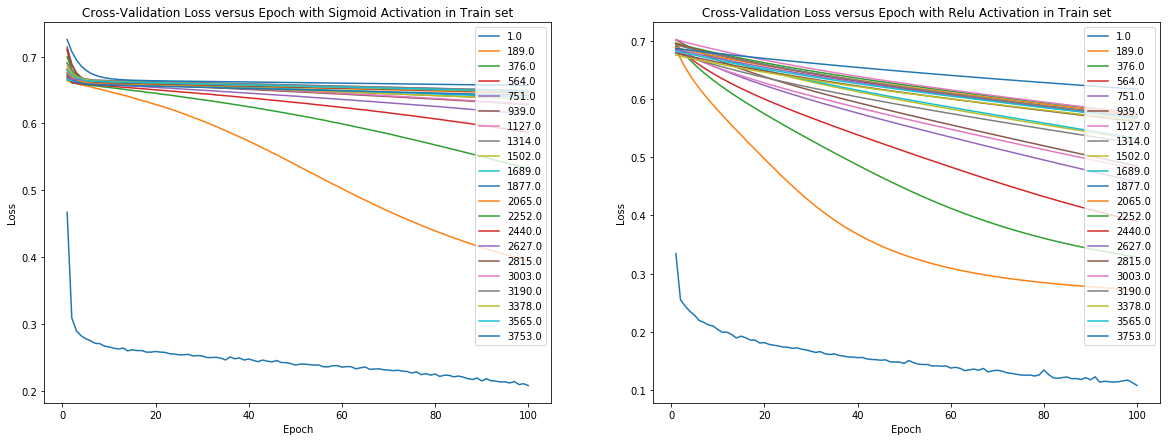

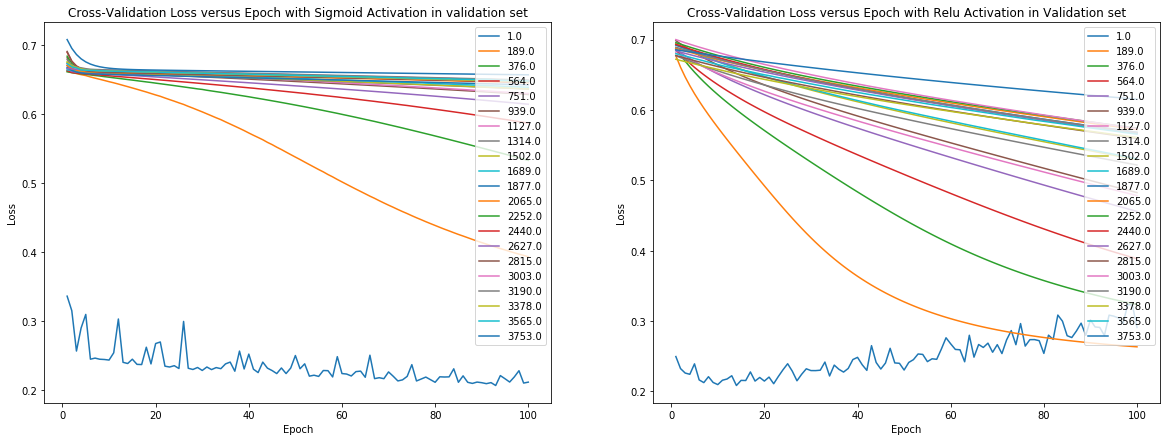

In [181]:
plot_loss_static(batch_sizes,batch_sig_dict,batch_relu_dict)
plot_loss_static(batch_sizes,batch_sig_dict,batch_relu_dict,"val")

Se puede observar lo lento que convergen las redes a medida que se aumenta el tamaño del mini batch. Para ver si se aumenta el desempeño al utilizar un mini batch de mayor tamaño habría que aumentar el número de Epoch en dicho entrenamiento, pues 100 es muy poco para el valor que se acerca más a los valores más utilizados en la práctica.

> _**h) Entrene los modelos obtenidos en c) utilizando estrategias modernas para adaptar la tasa de aprendizaje. Compare los desempeños de adagrad, adadelta, RMSprop y adam, ofrecidos en keras optimizer. ¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de validación?**_

El problema de los puntos sillas y como evitarlos es de gran importancia durante el entrenamiento de redes neuronales. Una de las maneras de lidiar con este problema es utilizar algoritmos de entrenamiento con tasas de aprendizajes adaptativas, de tal manera que se aumente la tasa cuando la norma de los gradientes sea muy pequeña, y que se achique la tasa cuando la norma de los gradientes sea elevada. En este experimento se probarán 4 estrategias de tasas adaptativas: _Adagrad, RMSprop, Adadelta y Adam_. Adagrad utiliza una tasa de aprendizaje distinta para cada parámetro entrenable, donde utiliza una aproximación de la matriz de covarianza para ajustar los pesos, esta aproximación lleva a multiplicar la tasa de aprendizaje por el inverso de la norma de los gradientes, logrando así el resultado deseado. RMSprop aproxima la matriz de covarianza utilizando una media móvil, por lo que "olvida" las normas de los gradientes más viejos. Adadelta utiliza además la norma de los gradientes en la actualización, esto debido a que las "unidades no calzan", lo anterior es un poco contradictorio pues utiliza la norma del gradiente y no el inverso, lo que va en contra de lo planteado por estas técnicas. Por último, Adam corrige sesgos producidos en RMSprop y Adagrad, lo que se traduce en usar alguna de estas técnicas y mezclarla con la técnica de Momentum.

In [98]:
def get_sequential_model_without_optimizer(activation='sigmoid'):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation=activation))
    model.add(Dense(1, kernel_initializer='uniform',activation="sigmoid"))
    #model.compile(optimizer=SGD(lr=lr,decay=decay,momentum=momentum,nesterov=nesterov),loss='binary_crossentropy')
    return model

In [102]:
def adagrad_experiment(lr=0.01):
    model_sig = get_sequential_model_without_optimizer()
    model_relu = get_sequential_model_without_optimizer(activation='relu')
    opt = Adagrad(lr=lr)
    model_sig.compile(optimizer=opt,loss='binary_crossentropy')
    model_relu.compile(optimizer=opt,loss='binary_crossentropy')
    hist_sig = model_sig.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
    hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
    return hist_sig, hist_relu, model_sig, model_relu

def adadelta_experiment(lr=0.01):
    model_sig = get_sequential_model_without_optimizer()
    model_relu = get_sequential_model_without_optimizer(activation='relu')
    opt = Adadelta(lr=lr)
    model_sig.compile(optimizer=opt,loss='binary_crossentropy')
    model_relu.compile(optimizer=opt,loss='binary_crossentropy')
    hist_sig = model_sig.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
    hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
    return hist_sig, hist_relu, model_sig, model_relu

def RMSprop_experiment(lr=0.01):
    model_sig = get_sequential_model_without_optimizer()
    model_relu = get_sequential_model_without_optimizer(activation='relu')
    opt = RMSprop(lr=lr)
    model_sig.compile(optimizer=opt,loss='binary_crossentropy')
    model_relu.compile(optimizer=opt,loss='binary_crossentropy')
    hist_sig = model_sig.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
    hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
    return hist_sig, hist_relu, model_sig, model_relu

def adam_experiment(lr=0.01):
    model_sig = get_sequential_model_without_optimizer()
    model_relu = get_sequential_model_without_optimizer(activation='relu')
    opt = Adam(lr=lr)
    model_sig.compile(optimizer=opt,loss='binary_crossentropy')
    model_relu.compile(optimizer=opt,loss='binary_crossentropy')
    hist_sig = model_sig.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
    hist_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
    return hist_sig, hist_relu, model_sig, model_relu

In [170]:
def plot_opt_experiments():
    adagrad_sig, adagrad_relu, adagrad_model_sig, adagrad_model_relu = adagrad_experiment()
    adadelta_sig, adadelta_relu, adadelta_model_sig, adadelta_model_relu = adadelta_experiment()
    rmsprop_sig, rmsprop_relu, rmsprop_model_sig, rmsprop_model_relu = RMSprop_experiment()
    adam_sig, adam_relu, adam_model_sig, adam_model_relu = adam_experiment()
    
    plt.figure(figsize=(15,15))
    plt.subplot(221)
    plt.title("Cross-Entropy versus Epoch with sigmoid activation in train set")
    plt.xlabel("Epoch")
    plt.xlabel("Loss")
    plt.plot(adagrad_sig.history['loss'])
    plt.plot(adadelta_sig.history['loss'])
    plt.plot(rmsprop_sig.history['loss'])
    plt.plot(adam_sig.history['loss'])
    plt.legend(['Adagrad','Adadelta','RMSprop','Adam'])
    plt.subplot(222)
    plt.title("Cross-Entropy versus Epoch with ReLu activation in train set")
    plt.xlabel("Epoch")
    plt.xlabel("Loss")
    plt.plot(adagrad_relu.history['loss'])
    plt.plot(adadelta_relu.history['loss'])
    plt.plot(rmsprop_relu.history['loss'])
    plt.plot(adam_relu.history['loss'])
    plt.legend(['Adagrad','Adadelta','RMSprop','Adam'])
    plt.subplot(223)
    plt.title("Cross-Entropy versus Epoch with sigmoid activation in validation set")
    plt.xlabel("Epoch")
    plt.xlabel("Loss")
    plt.plot(adagrad_sig.history['val_loss'])
    plt.plot(adadelta_sig.history['val_loss'])
    plt.plot(rmsprop_sig.history['val_loss'])
    plt.plot(adam_sig.history['val_loss'])
    plt.legend(['Adagrad','Adadelta','RMSprop','Adam'])
    plt.subplot(224)
    plt.title("Cross-Entropy versus Epoch with ReLu activation in validation set")
    plt.xlabel("Epoch")
    plt.xlabel("Loss")
    plt.plot(adagrad_relu.history['val_loss'])
    plt.plot(adadelta_relu.history['val_loss'])
    plt.plot(rmsprop_relu.history['val_loss'])
    plt.plot(adam_relu.history['val_loss'])
    plt.legend(['Adagrad','Adadelta','RMSprop','Adam'])
    plt.show()

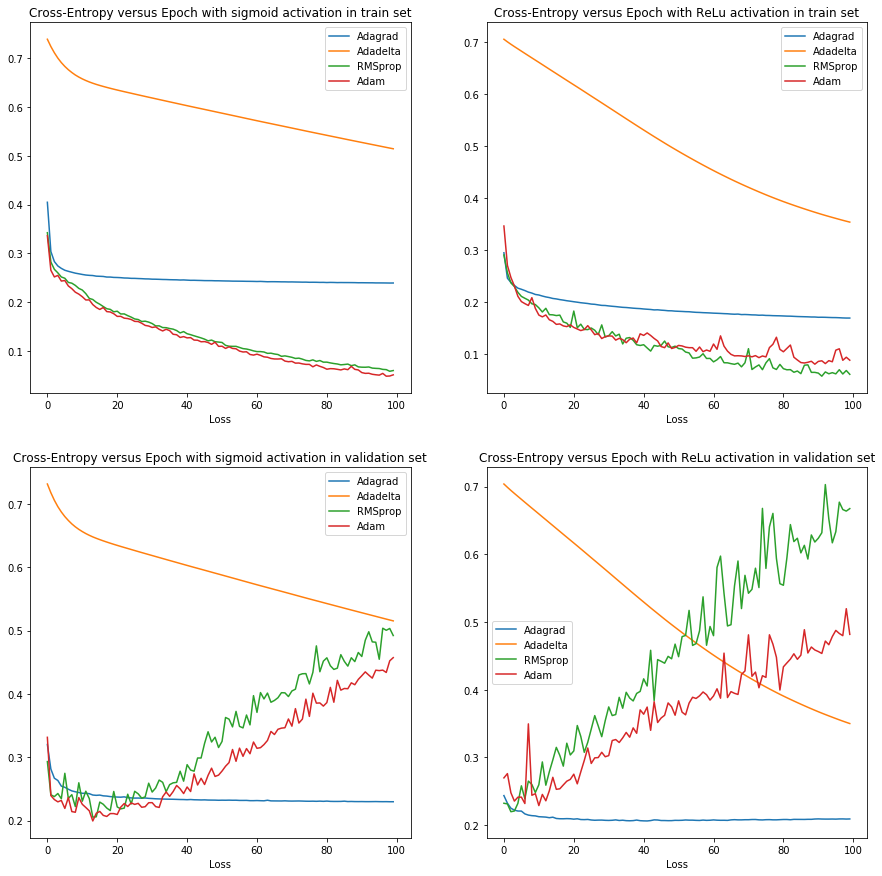

In [171]:
plot_opt_experiments()

En términos de entrenamiento, se observa que RMSprop y Adam obtienen mejor rendimiento, sin embargo, al observar los resultados en el set de validación se ve que es debido a que se produjo overfitting al utilizar ambas técnicas, situación que no se produce al utilizar Adagrad y Adadelta, una opción para mejorar los desempeños de ambos algoritmos es utilizar algún regularizador para contrarrestar el overfit. 
Por otro lado, al utilizar adadelta se observa que no alcanza a lograr la convergencia en los 100 Epoch, por lo que de entrenar más se podría mejorar los resultados al utilizar esta técnica. En términos de error de valición, la que obtiene mejores resultados es Adagrad, la cual converge más rápido que las otras técnicas.

> _**i) Entrene los modelos obtenidos en c) utilizando regularizadores clásicos  $l_1$  y  $l_2$  (weight decay). Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa vs la segunda, comente. Recuerde que la regularización se debe añadir a cada capa separadamente ¿Dónde le parece más importante aplicar?**_

Las técnicas de regularización son métodos para evitar el overfitting durante el entrenamiento. Una de estas técnicas el penalizar la complejidad del modelo, lo que provoca que la red neuronal decida implementar funciones más complejas solo si vale la pena durante el entrenamiento. Cuando se regulariza mediante penalización se agrega un término a la función objetivo (Loss Function), de tal manera de lograr un objetivo determinado, cuyo impacto va regulado mediante un parámetro de regularización.

$$ \sum_{i = 1}^{n} L\left(y^{(i)}, f(x^{i})\right) + \lambda \Omega(f)$$

Este regularizador actuará sobre los parámetros del modelo.

En este caso se utilizarán los regularizadores $l_1$ y $l_2$. El regularizador $l_2$ o regularizador de Tikhnov utiliza la norma $l_2$ del vector de pesos como función de penalización, multiplicado por la constante de regularización dividida por 2.

$$ E_{reg}(w) = E(w) + \frac{\lambda}{2}||w||_{l2}^{2}$$

Esto provocará que los pesos sean muy cercanos a 0, a no ser que el entrenamiento indique que dicho peso necesite tener valor. Generalmente esta reducción se producirá en aquellos parámetros cuya dirección apunte a lugares con baja curvatura del objetivo. Sin embargo, el hecho de que el valor de un peso no sea 0 puede trae consecuencias no deseadas, en dicho caso es mejor utilizar un regularizador con normal $l_1$, el cual producirá que el valor del peso sea efectivamente 0 (se utiliza como una aproximación a la norma $l_0$.

$$ E_{reg} = E(w) + \lambda ||w||_{l_1}$$

En este caso se utilizarán 10 constantes de regularización para cada método, obtenidas desde un espacio lineal entre 0 y 1. Se analizará el efecto de los regularizadores para cada capa y en ambas capas.

In [118]:
def get_sequential_reg(reg, activation='sigmoid', reg_type='l1',layer='both',lr=0.01):
    if reg_type == 'l1':
        regularizer=l1(reg)
    else:
        regularizer=l2(reg)
    if layer == 'both':
        model = Sequential()
        model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',kernel_regularizer=regularizer))
        model.add(Activation(activation)) #and relu
        model.add(Dense(1, kernel_initializer='uniform',kernel_regularizer=regularizer))
        model.add(Activation('sigmoid'))
    elif layer == 'first':
        model = Sequential()
        model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',kernel_regularizer=regularizer))
        model.add(Activation(activation)) #and relu
        model.add(Dense(1, kernel_initializer='uniform'))
        model.add(Activation('sigmoid'))
    elif layer == 'second':
        model = Sequential()
        model.add(Dense(256,input_dim=X_train_scaled.shape[1],kernel_initializer='uniform'))
        model.add(Activation(activation)) #and relu
        model.add(Dense(1, kernel_initializer='uniform',kernel_regularizer=regularizer))
        model.add(Activation('sigmoid'))
    model.compile(optimizer=SGD(lr=lr),loss='binary_crossentropy')
    return model

In [129]:
split_space = 10
reg_list = np.linspace(0,1,split_space)

def reg_experiment_layer(iterations=1,reg_type='l1',layer='first'):
    l1_sigmoid_dict = dict()
    l1_relu_dict = dict()
    model_l1_sigmoid_dict = dict()
    model_l1_relu_dict = dict()
    
    for reg in reg_list:
        sigmoid_l1_list = []
        relu_l1_list = []
        for i in range(iterations):
        # Training FF with sigmoid activation
            model_l1_sigmoid = get_sequential_reg(reg=reg,activation='sigmoid',reg_type=reg_type,layer=layer)
            hist_l1_sigmoid = model_sigmoid.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            sigmoid_l1_list.append(hist_l1_sigmoid)
            # Training FF with relu activation
            model_l1_relu = get_sequential_reg(reg=reg,activation='relu',reg_type='l1',layer='first')
            hist_l1_relu = model_relu.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
            relu_l1_list.append(hist_l1_relu)

        l1_sigmoid_dict[str(reg)] = sigmoid_l1_list
        l1_relu_dict[str(reg)] = relu_l1_list
        model_l1_sigmoid_dict[str(reg)] = model_l1_sigmoid
        model_l1_relu_dict[str(reg)] = model_l1_relu
    return l1_sigmoid_dict, l1_relu_dict, model_l1_sigmoid_dict, model_l1_relu_dict
    

In [123]:
def plot_loss_reg(reg, reg_sig,reg_relu,model_reg_sig,model_reg_relu, reg_type):
    sig_list = reg_sig[str(reg)]
    relu_list = reg_relu[str(reg)]
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.title("Cross-Entropy Loss, with sigmoid activation, "+reg_type+" = "+str(reg))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    for i in sig_list:
        plt.plot(i.history['loss'],color="blue")
        plt.plot(i.history['val_loss'],color="green")
    plt.legend(['Train set','Validation set'],loc='upper right')
    plt.subplot(122)
    plt.title("Cross-Entropy Loss, with relu activation, "+reg_type+" = "+str(reg))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    for i in relu_list:
        plt.plot(epoch_list,i.history['loss'],color="red")
        plt.plot(epoch_list,i.history['val_loss'],color="yellow")
    plt.legend(['Train Set','Validation Set'],loc='upper right')
    plt.show()
    f1_score_sigmoid = f1_score(y_test,model_reg_sig[str(reg)].predict_classes(X_test_scaled),average='weighted')
    f1_score_relu = f1_score(y_test,model_reg_relu[str(reg)].predict_classes(X_test_scaled),average='weighted')
    print("F1 Score Sigmoid: "+str(f1_score_sigmoid))
    print("F1 Score Relu: "+str(f1_score_relu))

### Regularizadores en la primera capa

In [130]:
l1_sig, l1_relu, model_l1_sig, model_l1_relu = reg_experiment_layer()

In [133]:
interact(plot_loss_reg,reg=reg_list,reg_sig=fixed(l1_sig),reg_relu=fixed(l1_relu),model_reg_sig=fixed(model_l1_sig),model_reg_relu=fixed(model_l1_relu),reg_type=fixed('l1'))

interactive(children=(Dropdown(description='reg', options=(0.0, 0.1111111111111111, 0.2222222222222222, 0.3333…

<function __main__.plot_loss_reg(reg, reg_sig, reg_relu, model_reg_sig, model_reg_relu, reg_type)>

Si bien, en el gráfico interactivo las curvas se ven muy distantes entre sí, se observa como se reduce el rango del eje y, lo que indica que se logra el objetivo de disminuir el overfitting, siendo esto más efectivo a medida que se aumenta el parámetro de regularización. Sin embargo, se observa un efecto adverso en términos del F1-score, lo que indica que al utilizar regularización el modelo preferirá clasificar la gran mayoría los ejemplos con una determinada clase (considerando el problema del desbalance). Se observa que el efecto del regularizador para reducir el overfitting no tiene la misma efectividad en la red con activación ReLu, quizás se deba a que dicha función propaga más el error, por lo que el regularizador no tiene tanto efecto. También se observa que la red con activación ReLu converge rápidamente. Para ver de mejor manera la mejoría se presentan los siguientes gráficos

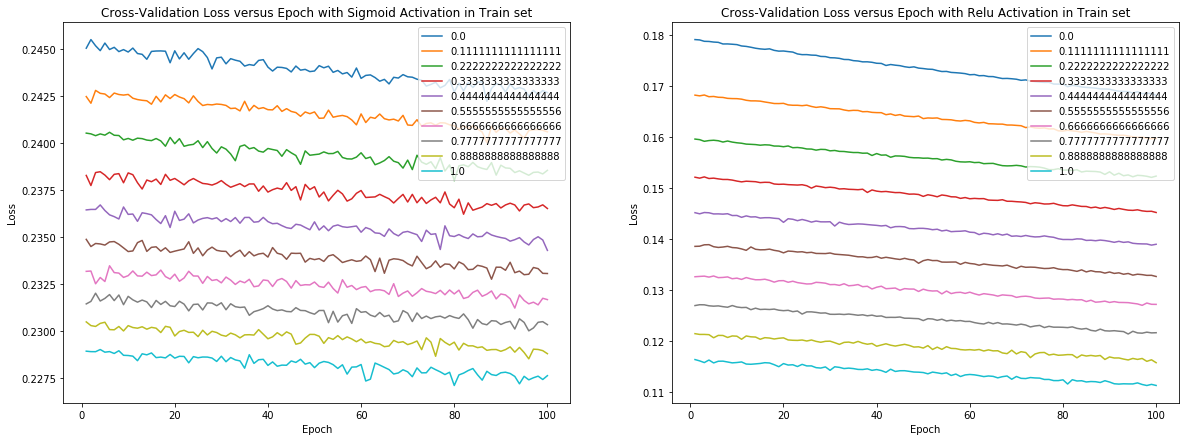

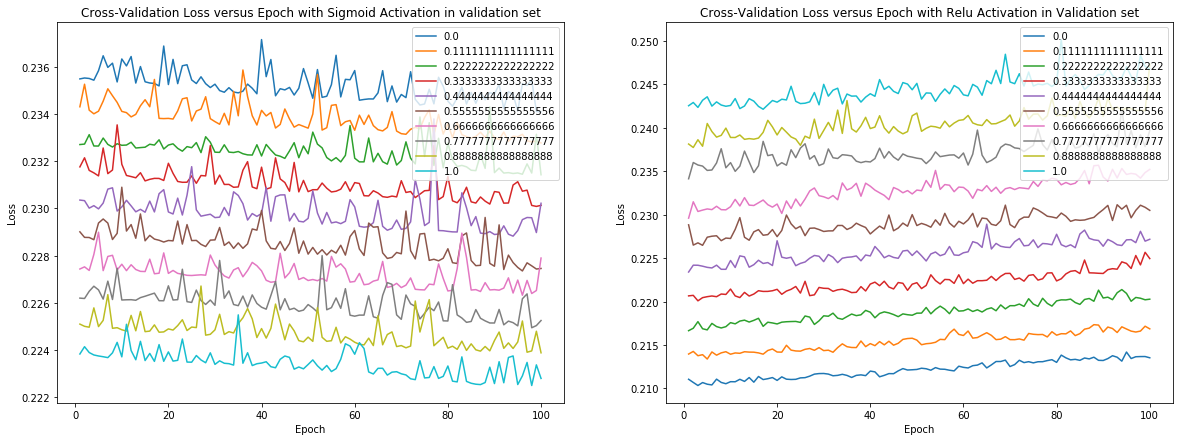

In [182]:
plot_loss_static(reg_list,l1_sig,l1_relu)
plot_loss_static(reg_list,l1_sig,l1_relu,"val")

Se observa como el hecho de utilizar el regularizador mejora los resultados en ambos conjuntos (entrenamiento y validación) en la red con activación Sigmoidal. En la red con activación ReLu se puede observar como el desempeño en el conjunto de validación empeora ligeramente conforme pasan las Epoch.

In [134]:
l2_sig, l2_relu, model_l2_sig, model_l2_relu = reg_experiment_layer(reg_type='l2')

In [135]:
interact(plot_loss_reg,reg=reg_list,reg_sig=fixed(l2_sig),reg_relu=fixed(l2_relu),model_reg_sig=fixed(model_l2_sig),model_reg_relu=fixed(model_l2_relu),reg_type=fixed('l2'))

interactive(children=(Dropdown(description='reg', options=(0.0, 0.1111111111111111, 0.2222222222222222, 0.3333…

<function __main__.plot_loss_reg(reg, reg_sig, reg_relu, model_reg_sig, model_reg_relu, reg_type)>

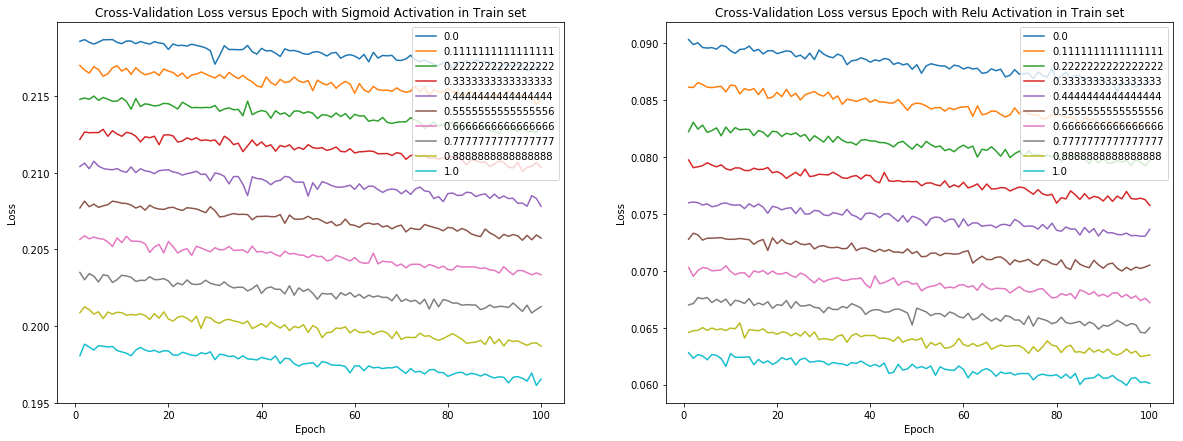

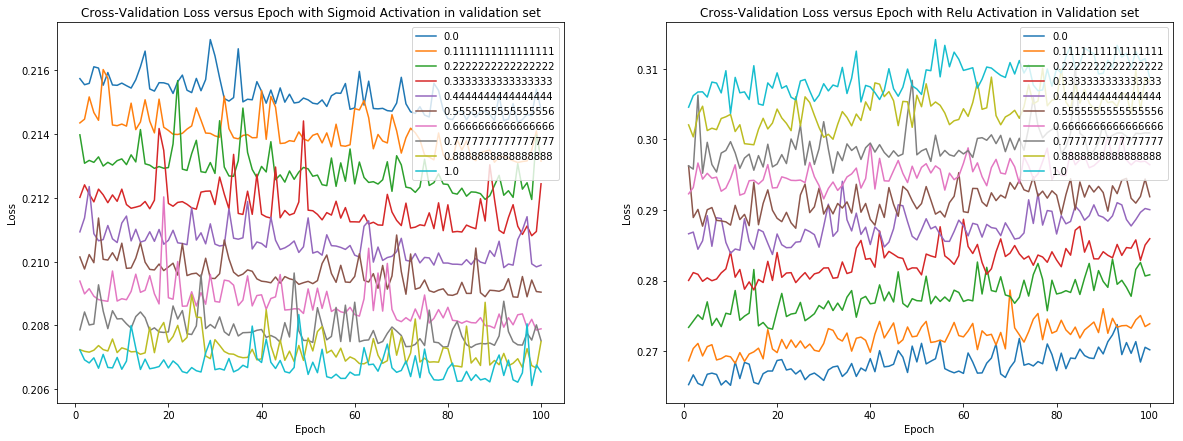

In [183]:
plot_loss_static(reg_list,l2_sig,l2_relu)
plot_loss_static(reg_list,l2_sig,l2_relu,"val")

El efecto observado en el conjunto de validación para la red con activación ReLu con regularización $l_1$ se vuelve más notorio al utilizar la regularización $l_1$, donde se aprecia que no se logra el objetivo deseado, el cual es reducir el overfit. También se observa que el desempeño en el conjunto de validación es más irregular en el caso de la red con activación Sigmoidal, presentando spikes más pronunciados. Esto quizás se deba a los pesos que en este caso ya no serían 0, sino un valor muy bajo.

### Regularizadores en la segunda capa

In [136]:
l1_sec_sig, l1_sec_relu, model_l1_sec_sig, model_l1_sec_relu = reg_experiment_layer(layer='second')

In [137]:
interact(plot_loss_reg,reg=reg_list,reg_sig=fixed(l1_sec_sig),reg_relu=fixed(l1_sec_relu),model_reg_sig=fixed(model_l1_sec_sig),model_reg_relu=fixed(model_l1_sec_relu),reg_type=fixed('l1'))

interactive(children=(Dropdown(description='reg', options=(0.0, 0.1111111111111111, 0.2222222222222222, 0.3333…

<function __main__.plot_loss_reg(reg, reg_sig, reg_relu, model_reg_sig, model_reg_relu, reg_type)>

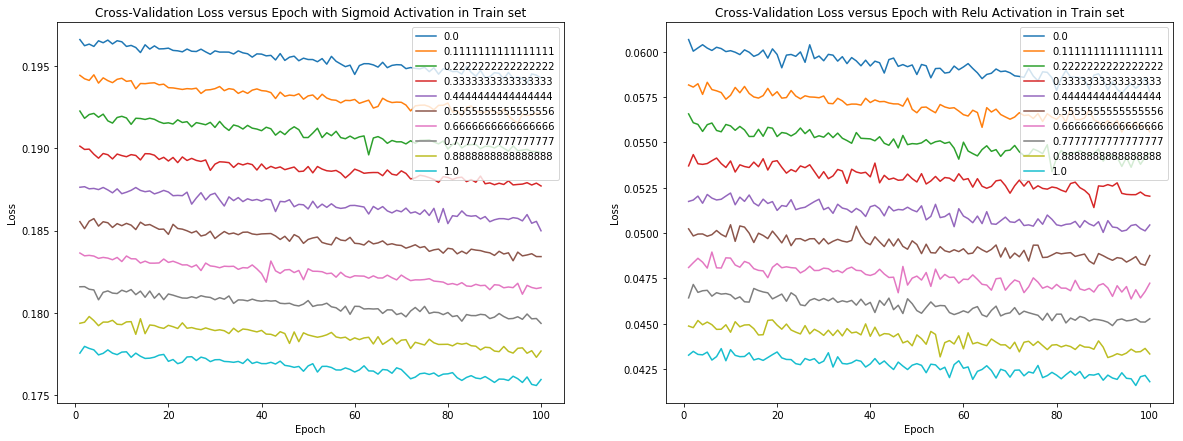

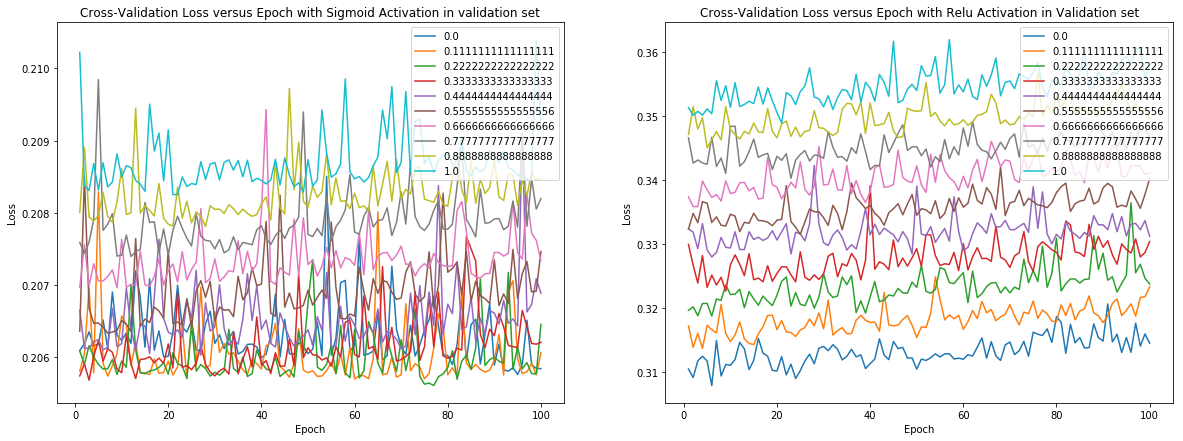

In [184]:
plot_loss_static(reg_list,l1_sec_sig,l1_sec_relu)
plot_loss_static(reg_list,l1_sec_sig,l1_sec_relu,"val")

Al utilizar regularización $l_1$ en la segunda capa se obtienen peores resultados que al aplicarla en la primera capa. Es muy probable que esto se deba a que el modelo contará con mucha menos información para tomar la decisión de asignar cada dato a una clase, lo que podría empeorar los resultados. Además se observa que el hecho de aumentar el parámetro de regularización empeora el Overfitting, no lo mejora.

In [138]:
l2_sec_sig, l2_sec_relu, model_l2_sec_sig, model_l2_sec_relu = reg_experiment_layer(reg_type='l2',layer='second')

In [139]:
interact(plot_loss_reg,reg=reg_list,reg_sig=fixed(l2_sec_sig),reg_relu=fixed(l2_sec_relu),model_reg_sig=fixed(model_l2_sec_sig),model_reg_relu=fixed(model_l2_sec_relu),reg_type=fixed('l2'))

interactive(children=(Dropdown(description='reg', options=(0.0, 0.1111111111111111, 0.2222222222222222, 0.3333…

<function __main__.plot_loss_reg(reg, reg_sig, reg_relu, model_reg_sig, model_reg_relu, reg_type)>

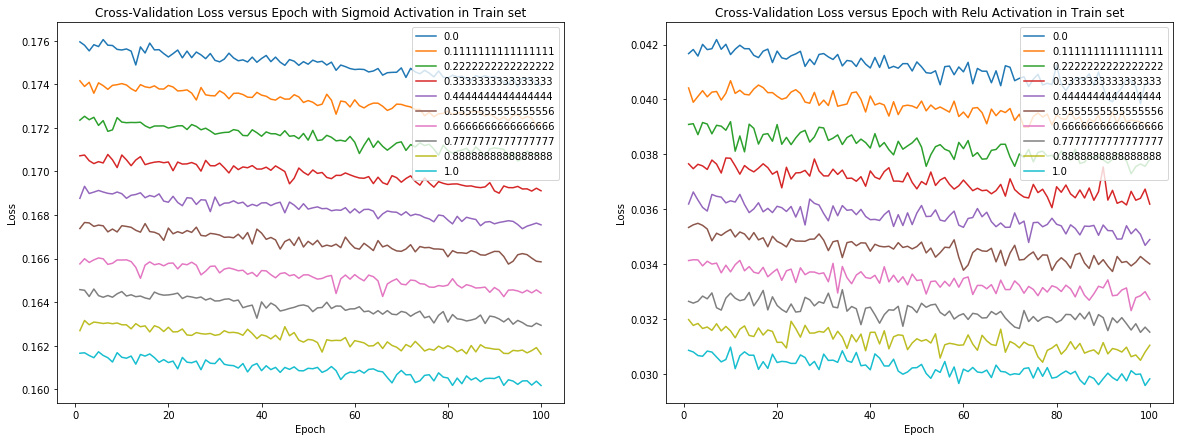

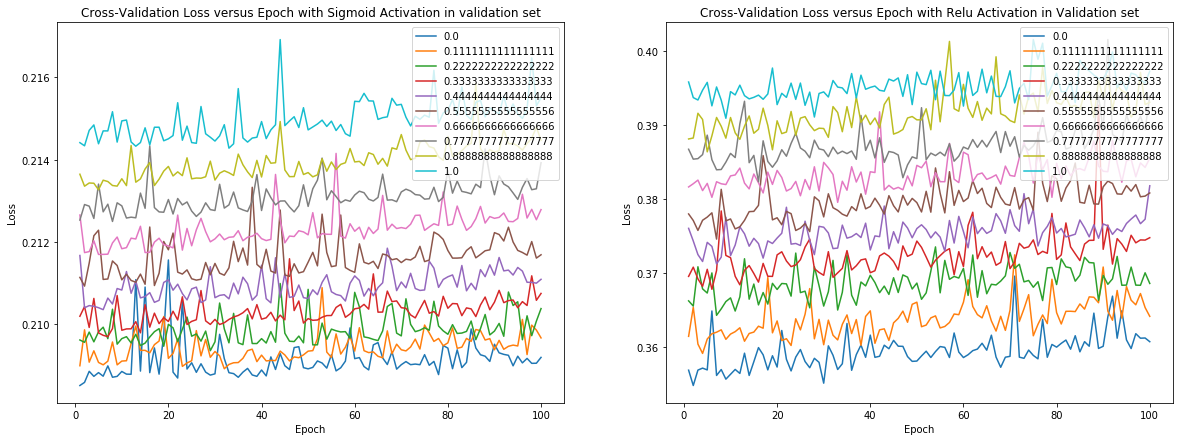

In [185]:
plot_loss_static(reg_list,l2_sec_sig,l2_sec_relu)
plot_loss_static(reg_list,l2_sec_sig,l2_sec_relu,"val")

Si ahora se aplica regularización $l_2$ en la segunda capa se empeoran los resultados obtenidos al aplicar la regularización con norma $l_1$, es decir, se acentúa aún más el problema del overfitting. 

De estos dos experimentos se llega a la conclusión de que aplicar regularización en la capa de salida conlleva un empeoramiento del desempeño en el conjunto de pruebas, probablemente debido a que esta capa contará con menos información para tomar una decición.

### Regularizadores en ambas capas

In [140]:
l1_both_sig, l1_both_relu, model_l1_both_sig, model_l1_both_relu = reg_experiment_layer(layer='both')

In [141]:
interact(plot_loss_reg,reg=reg_list,reg_sig=fixed(l1_both_sig),reg_relu=fixed(l1_both_relu),model_reg_sig=fixed(model_l1_both_sig),model_reg_relu=fixed(model_l1_both_relu),reg_type=fixed('l1'))

interactive(children=(Dropdown(description='reg', options=(0.0, 0.1111111111111111, 0.2222222222222222, 0.3333…

<function __main__.plot_loss_reg(reg, reg_sig, reg_relu, model_reg_sig, model_reg_relu, reg_type)>

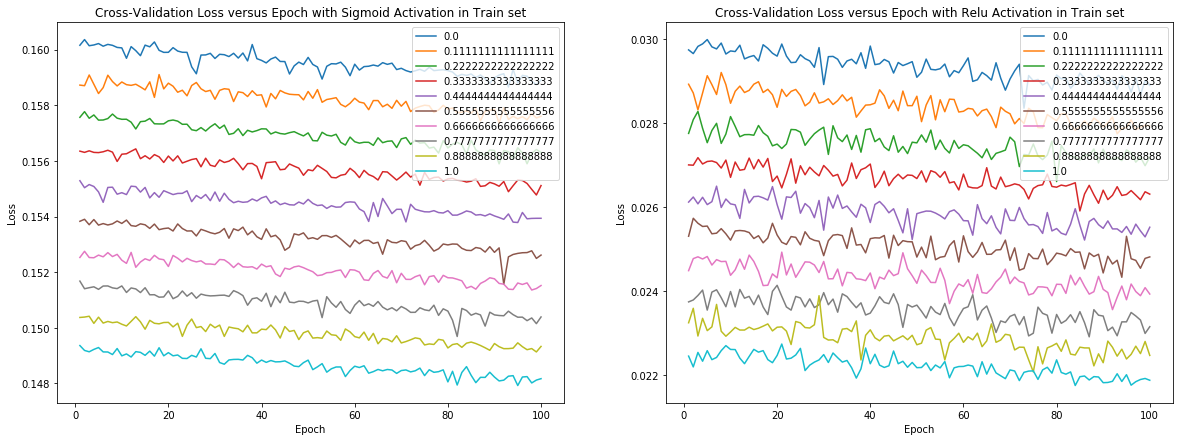

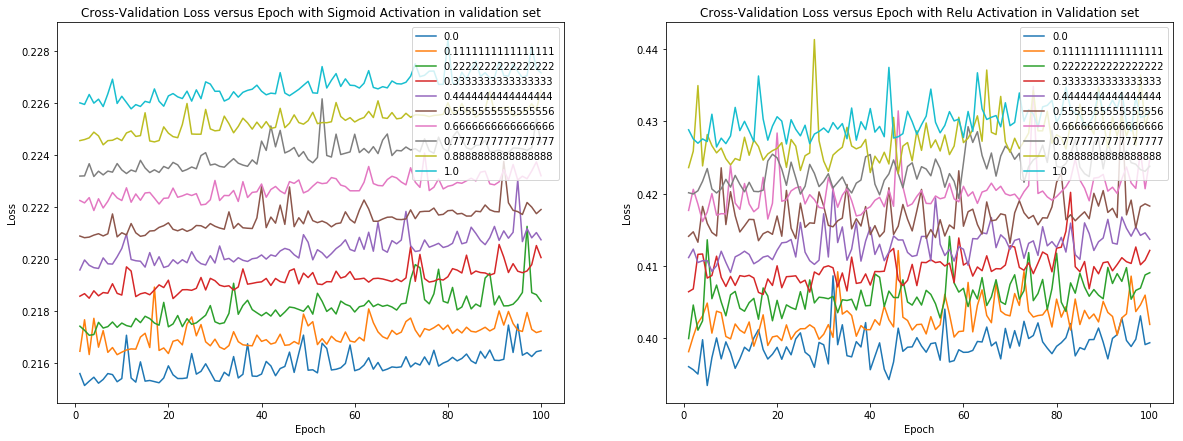

In [186]:
plot_loss_static(reg_list,l1_both_sig,l1_both_relu)
plot_loss_static(reg_list,l1_both_sig,l1_both_relu,"val")

In [144]:
l2_both_sig, l2_both_relu, model_l2_both_sig, model_l2_both_relu = reg_experiment_layer(reg_type='l2',layer='both')

In [145]:
interact(plot_loss_reg,reg=reg_list,reg_sig=fixed(l2_both_sig),reg_relu=fixed(l2_both_relu),model_reg_sig=fixed(model_l2_both_sig),model_reg_relu=fixed(model_l2_both_relu),reg_type=fixed('l2'))

interactive(children=(Dropdown(description='reg', options=(0.0, 0.1111111111111111, 0.2222222222222222, 0.3333…

<function __main__.plot_loss_reg(reg, reg_sig, reg_relu, model_reg_sig, model_reg_relu, reg_type)>

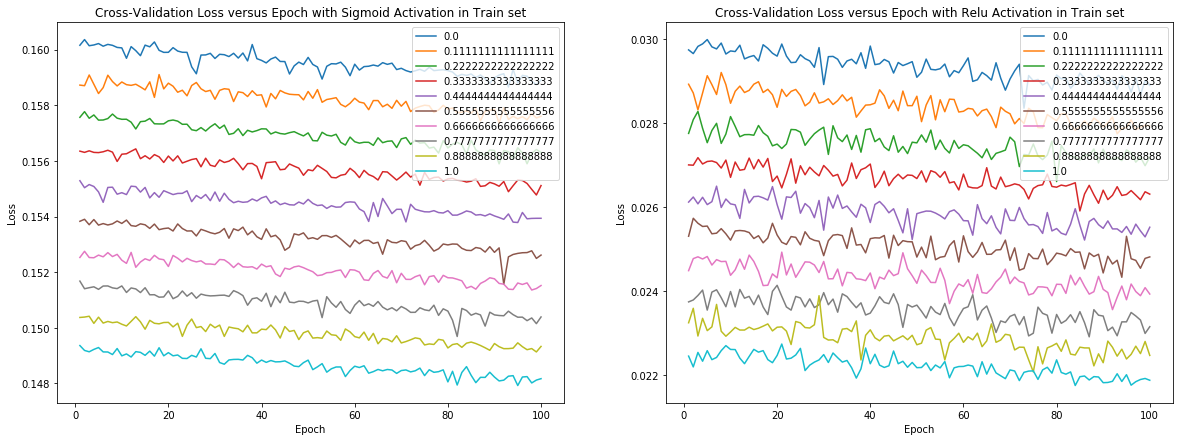

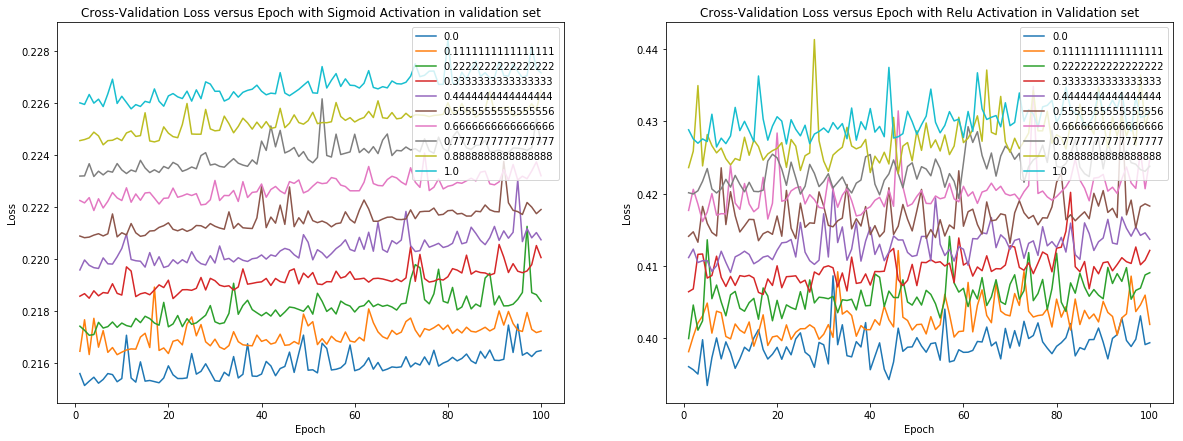

In [187]:
plot_loss_static(reg_list,l1_both_sig,l1_both_relu)
plot_loss_static(reg_list,l1_both_sig,l1_both_relu,"val")

Aplicando regularización en ambas capas empeora el desempeño de la técnica en la red con activación Sigmoidal y regularizador en la primera capa, donde ahora no logra reducir el overfitting tan efectivamente como en el primer caso. 

> _**j) Elija uno de los dos modelos definidos en c) y experimente con modificar la función objetivo, que hasta ahora se lo hemos dejado a keras definir la típica binary cross entropy, en pos de algún objetivo que decida plantearse, por ejemplo aumentar la velocidad de convergencia (reducir más rápida la función objetivo), obtener mejor desempeño en f1 score u algún otro.**_

In [51]:
# def focal_loss(gamma,alpha):
#     def loss(y_true, y_pred):
#         y_true = K.clip(y_true, K.epsilon(),1)
#         y_pred = K.clip(y_pred, K.epsilon(),1)
#         elems = (y_pred, y_true)
#         p_t = K.map_fn(lambda x: x[0] if x[1] == 0 else 1 - x[0],elems,dtype='float32')
#         return K.sum(-alpha*K.pow(1 - p_t,gamma)*K.log(p_t),axis=-1)
#     return loss

def cross_entropy(gamma):
    def loss(y_true,y_pred):
        y_true = K.clip(y_true, K.epsilon(), 1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return K.sum(-(y_true*K.log(y_pred)+(1 - y_true)*K.log(1 - y_pred)),axis=-1)
    return loss

def focal_loss(gamma,alpha):
    def loss(y_true,y_pred):
        y_true = K.clip(y_true, K.epsilon(), 1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return K.sum(-alpha*(y_true*K.pow(1 - y_pred,gamma)*K.log(y_pred) + (1 - y_true)*K.pow(y_pred,gamma)*K.log(1 - y_pred)),axis=-1)
#         return K.sum(-alpha*((1-y_true)*K.pow(1 - y_pred,gamma)*K.log(y_pred) + (y_true)*K.pow(y_pred,gamma)*K.log(1 - y_pred)),axis=-1)
    return loss

In [84]:
model_FL = Sequential()
model_FL.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation='relu'))
model_FL.add(Dense(1, kernel_initializer='uniform',activation="sigmoid"))
model_FL.compile(optimizer=SGD(lr=0.01),loss=focal_loss(2,1))

model_CE = get_sequential_model(lr=0.01)

def custom_loss_model(lr=0.01,activation='relu',loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1],kernel_initializer='uniform',activation=activation))
    model.add(Dense(1, kernel_initializer='uniform',activation="sigmoid"))
    model.compile(optimizer=SGD(lr=lr),loss=loss)
    return model

In [85]:
def focal_loss_experiment(iterations=5):
    focal_f1_list = []
    crossentropy_f1_list = []
    focal_f1_test_list = []
    crossentropy_f1_test_list = []
    for i in range(iterations):
        model_FL = custom_loss_model(loss=focal_loss(2,1))
        model_CE = custom_loss_model()
        model_FL.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
        model_CE.fit(X_train_scaled,y_train,epochs=100,verbose=0,validation_data=(X_val_scaled,y_val))
        focal_f1_list.append(f1_score(y_val,model_FL.predict_classes(X_val_scaled),average='weighted'))
        crossentropy_f1_list.append(f1_score(y_val,model_CE.predict_classes(X_val_scaled),average='weighted'))
        focal_f1_test_list.append(f1_score(y_test,model_FL.predict_classes(X_test_scaled),average='weighted'))
        crossentropy_f1_test_list.append(f1_score(y_test,model_CE.predict_classes(X_test_scaled),average='weighted'))
    return focal_f1_list, crossentropy_f1_list, focal_f1_test_list, crossentropy_f1_test_list    

In [ ]:
focal, crossentropy, focal_test, crossentropy_test = focal_loss_experiment(10)

1216/1565 [======================>.......] - ETA: 0s

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title("Boxplot of F1-Score on Validation Set")
plt.boxplot([focal,crossentropy])
plt.xticks([1,2],['Focal Loss','Cross-Entropy Loss'])
plt.subplot(122)
plt.title("Boxplot of F1-Score on Test Set")
plt.boxplot([focal_test,crossentropy_test])
plt.xticks([1,2],['Focal Loss','Cross-Entropy Loss'])

plt.show()